> edit

- GConvGRU
- DCRNN
- GConvLSTM
- MPNNLSTM
- TGCN
- EvolveGCNO
- GCLSTM
- LRGCN
- EvolveGCNH
- DyGrEncoder

# import

In [1]:
import itstgcn 
import torch
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import random

In [4]:
class Eval_csy:
    def __init__(self,learner,train_dataset):
        self.learner = learner
        # self.learner.model.eval()
        try:self.learner.model.eval()
        except:pass
        self.train_dataset = train_dataset
        self.lags = self.learner.lags
        rslt_tr = self.learner(self.train_dataset) 
        self.X_tr = rslt_tr['X']
        self.y_tr = rslt_tr['y']
        self.f_tr = torch.concat([self.train_dataset[0].x.T,self.y_tr],axis=0).float()
        self.yhat_tr = rslt_tr['yhat']
        self.fhat_tr = torch.concat([self.train_dataset[0].x.T,self.yhat_tr],axis=0).float()

In [5]:
import pickle
import pandas as pd

In [6]:
def load_data(fname):
    with open(fname, 'rb') as outfile:
        data_dict = pickle.load(outfile)
    return data_dict

def save_data(data_dict,fname):
    with open(fname,'wb') as outfile:
        pickle.dump(data_dict,outfile)

In [7]:
from plotnine import *

# Example

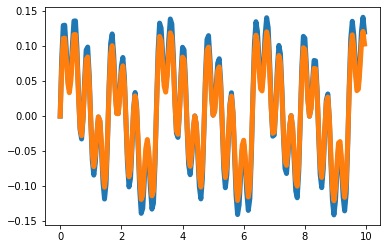

In [8]:
T = 200
t = np.arange(T)/T * 10
x = 0.1*np.sin(2*t)+0.2*np.sin(4*t)+0.1*np.sin(8*t)+0.2*np.sin(16*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
# for i in range(2,T):
#     y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.5*np.cos(0.5*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x*0.35
y = y*0.3
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

# _FX1 = np.stack([x,y],axis=1).tolist()
_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1],[1,0]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
#data_dict = itstgcn.load_data('./data/fivenodes.pkl')

save_data(data_dict1, './data/toy_example1.pkl')

data1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

save_data(data1, './data/toy_example_true1.csv')


In [9]:
data_dict1 = itstgcn.load_data('./data/toy_example1.pkl')
loader1 = itstgcn.DatasetLoader(data_dict1)

In [10]:
dataset05031 = loader1.get_dataset(lags=1)

In [11]:
mindex05031 = itstgcn.rand_mindex(dataset05031,mrate=0)
dataset_miss05031 = itstgcn.miss(dataset05031,mindex05031,mtype='rand')

/home/csy/Dropbox/blog/posts/GCN/itstgcn/utils.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/torch/csrc/utils/tensor_new.cpp:245.)


In [12]:
dataset_padded_cubic05031 = itstgcn.padding(dataset_miss05031,interpolation_method='cubic')

In [13]:
mindex = [random.sample(range(0, T), int(T*0.5)),[np.array(list(range(100,120)))]]
dataset_miss05031 = itstgcn.miss(dataset05031,mindex,mtype='block')

# GConvGRU

In [14]:
lrnr05031 = itstgcn.StgcnLearner(dataset_padded_cubic05031)

In [15]:
lrnr05031.learn(filters=8,epoch=50,RecurrentGCN='GConvGRU')

In [16]:
df1 = itstgcn.load_data('./data/toy_example_true1.csv')

In [17]:
evtor05031 = Eval_csy(lrnr05031,dataset_padded_cubic05031)

In [18]:
lrnr05032 = itstgcn.ITStgcnLearner(dataset_padded_cubic05031)

In [19]:
lrnr05032.learn(filters=8,epoch=50,RecurrentGCN='GConvGRU')

In [20]:
evtor05032 = Eval_csy(lrnr05032,dataset_padded_cubic05031)

```python
fig, ((ax1, ax2), (ax3, aRecurrentGCN=)) = plt.subplots(2, 2,figsize=(40,15))
fig.suptitle('Figure 1')
ax1.plot(df1['x'][:],'--.',color='C1')
ax1.plot(evtor05031.f_tr[:,0],'--.',color='C2')
ax1.plot(evtor05031.fhat_tr[:,0],color='C3',lw=3)
ax1.set_title('STGCN')
ax2.plot(df1['y'][:],'--.',color='C1')
ax2.plot(evtor05031.fhat_tr[:,1],color='C3',lw=3)
ax2.plot(evtor05031.f_tr[:,1],'--.',color='C2')
ax2.set_title('STGCN')
ax3.plot(df1['x'][:],'--.',color='C1')
ax3.plot(evtor05032.f_tr[:,0],'--.',color='C2')
ax3.plot(evtor05032.fhat_tr[:,0],color='C4',lw=3)
ax3.set_title('ITSTGCN')
ax4.plot(df1['y'][:],'--.',color='C1')
ax4.plot(evtor05032.f_tr[:,1],'--.',color='C2')
ax4.plot(evtor05032.fhat_tr[:,1],color='C4',lw=3)
ax4.set_title('ITSTGCN')

for ax in fig.get_axes():
    ax.label_outer()
```

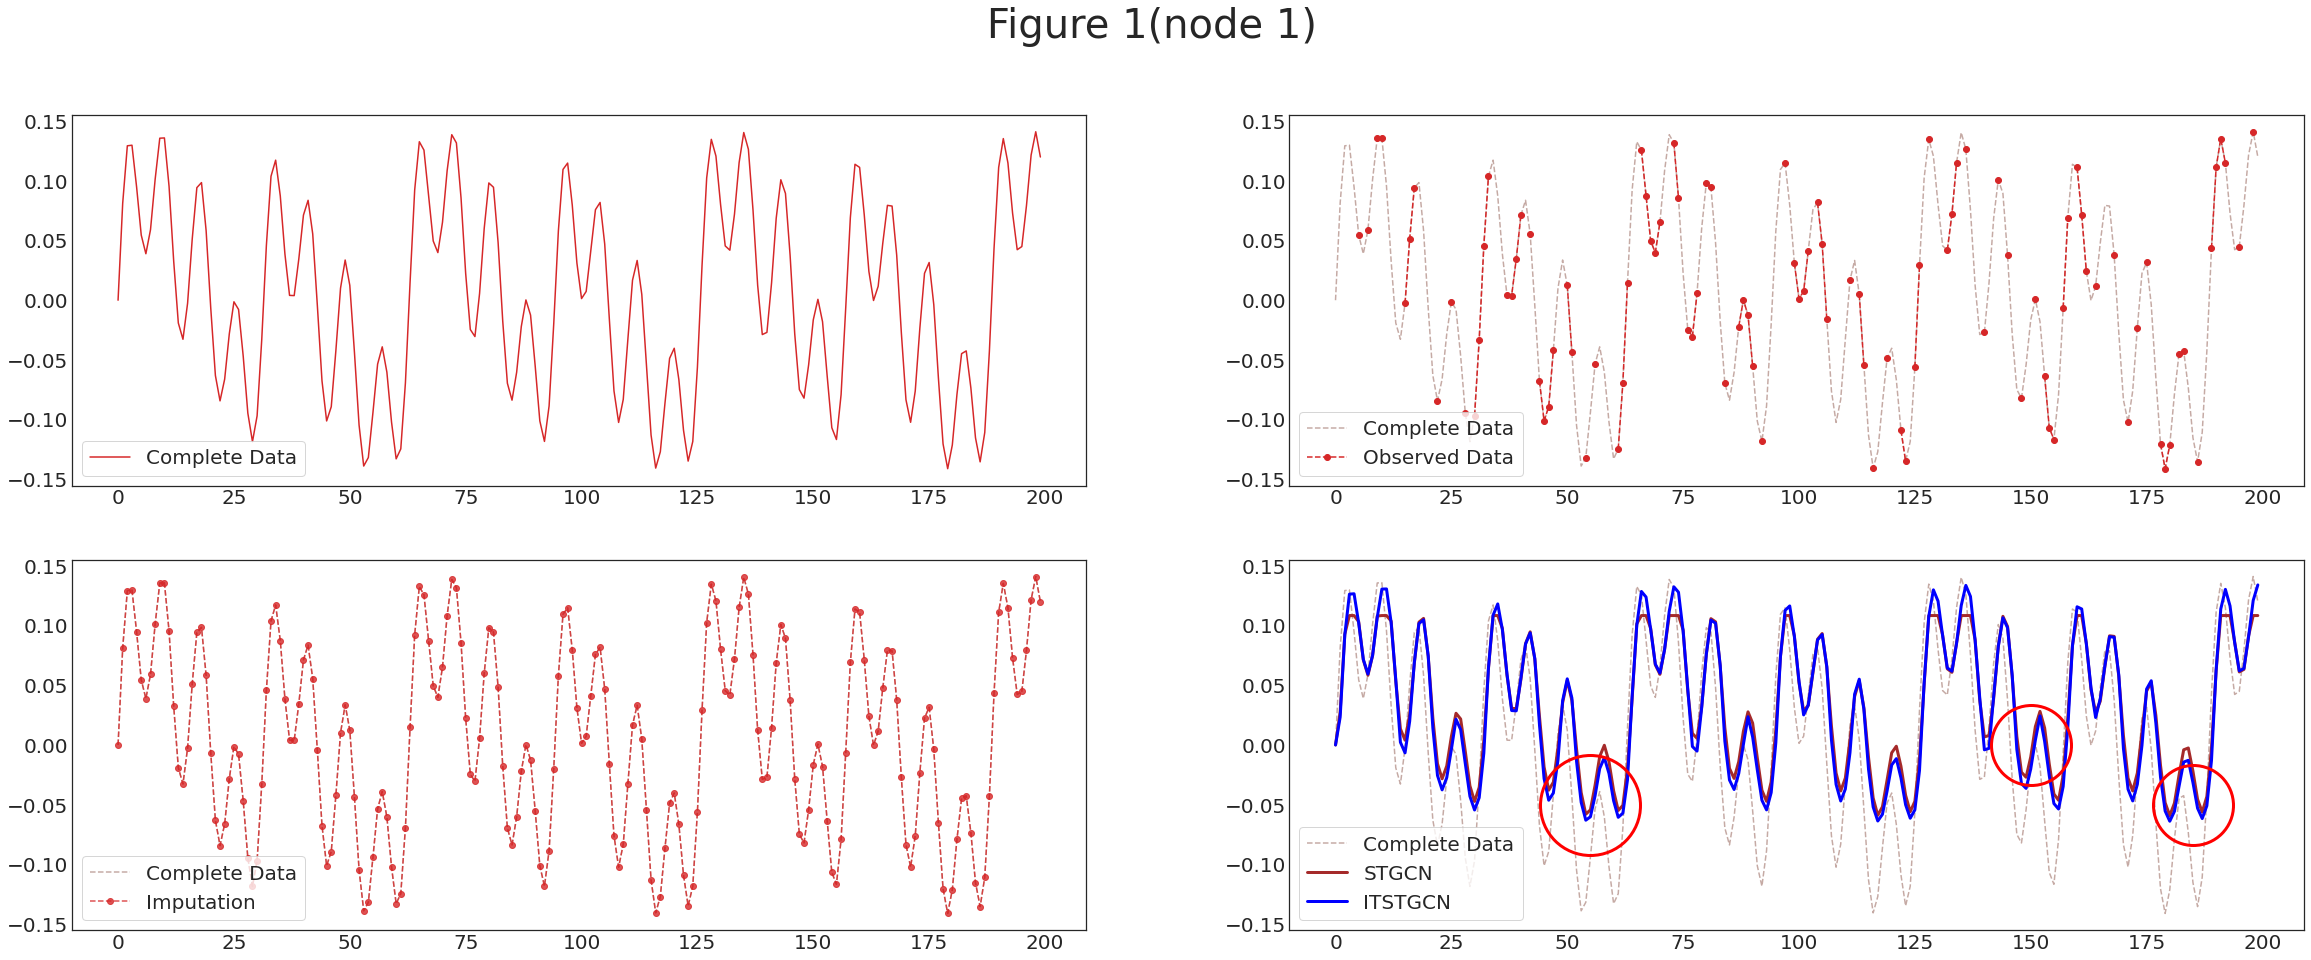

In [21]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss05031.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor05032.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor05031.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor05032.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    ax4.plot(55, -0.05, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.plot(185, -0.05, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

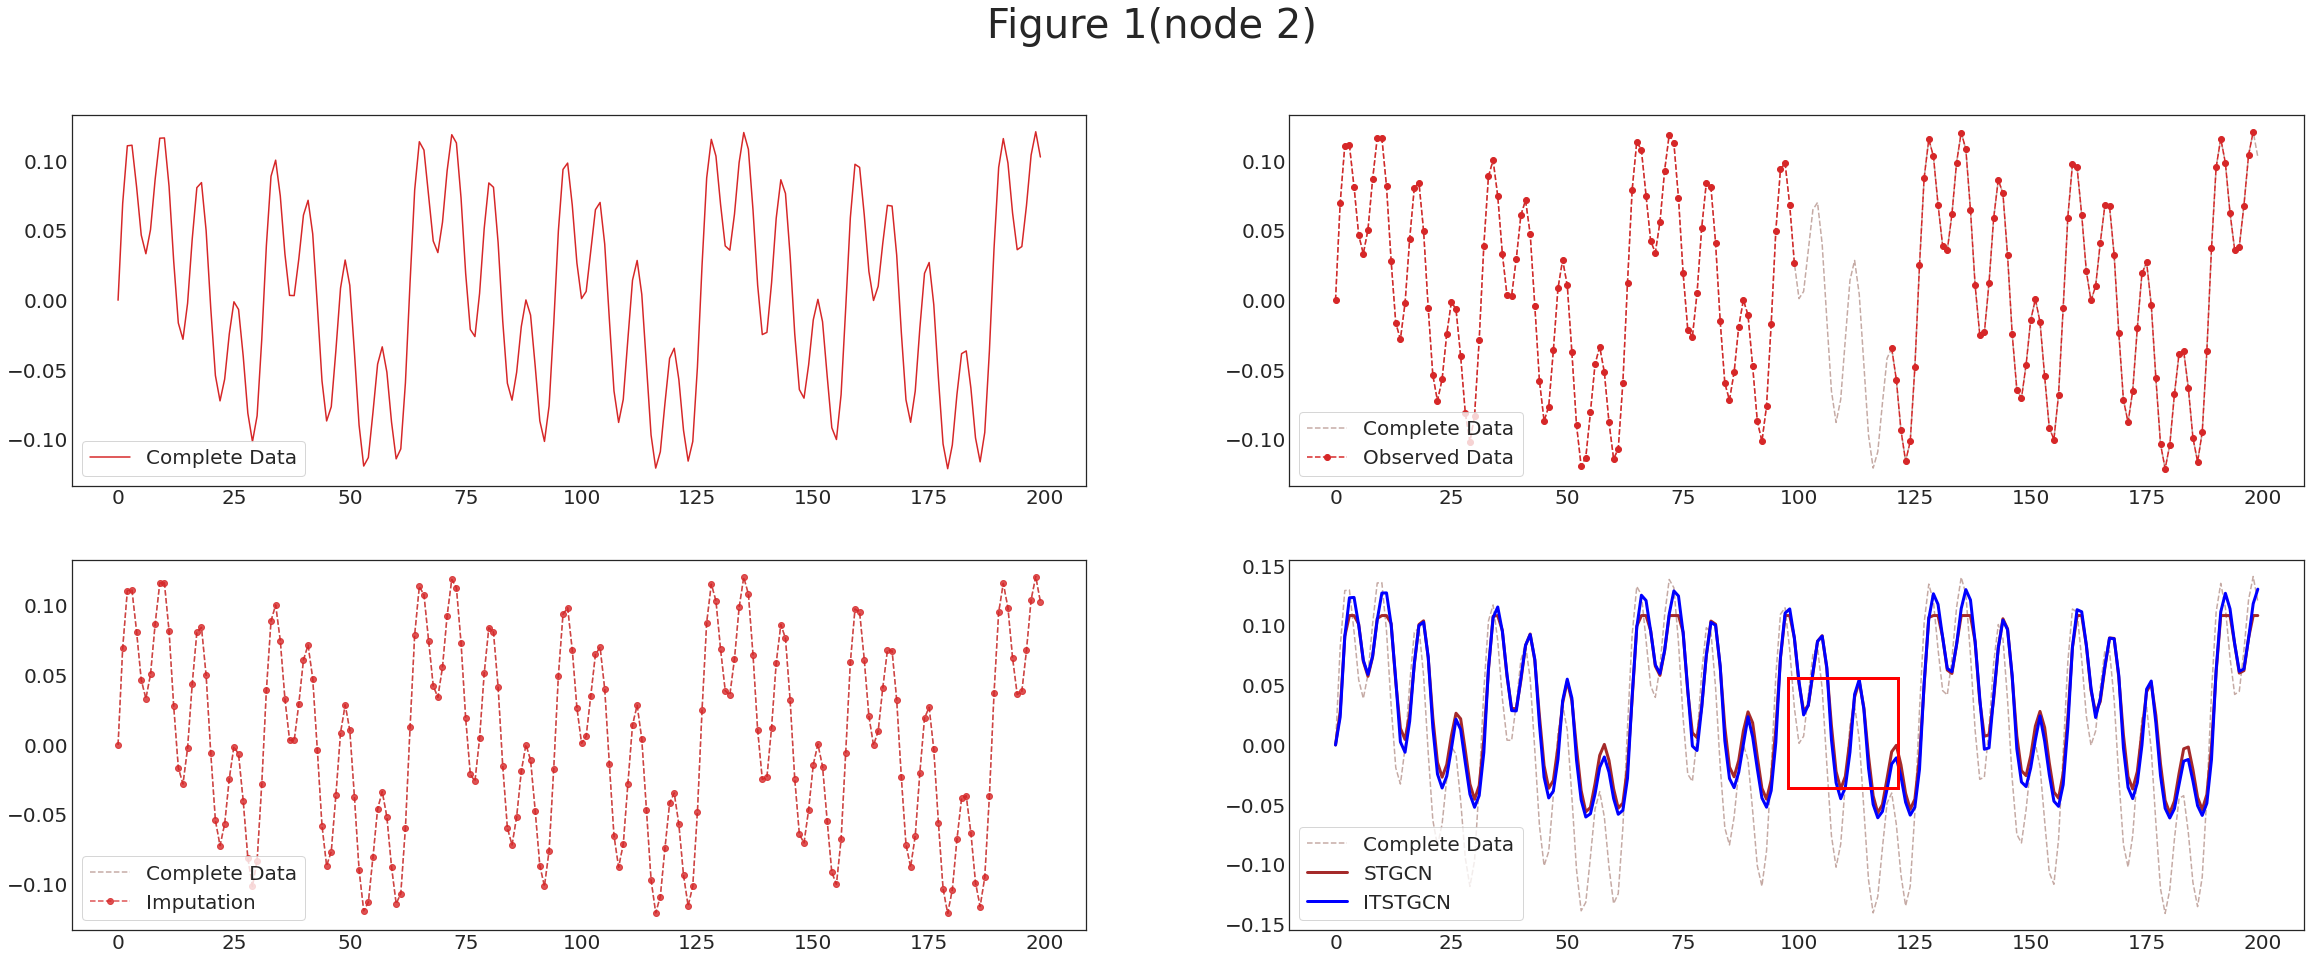

In [22]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss05031.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor05032.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor05031.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor05032.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, 0.01,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

# DCRNN

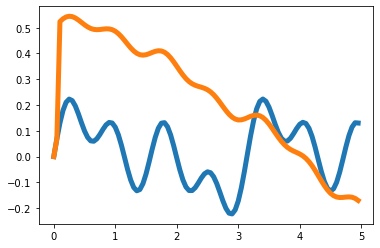

In [334]:
T = 100
t = np.arange(T)/T * 5

x = 0.1*np.sin(2*t)+0.1*np.sin(4*t)+0.1*np.sin(8*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
for i in range(2,T):
    y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.5*np.cos(0.4*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x
y = y
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [551]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [552]:
dataset_DCRNN = loader1.get_dataset(lags=1)

In [562]:
mindex = [[np.array(list(range(20,35)))],random.sample(range(0, T), int(T*0.5))]
dataset_miss_DCRNN = itstgcn.miss(dataset_DCRNN,mindex,mtype='block')

In [563]:
dataset_padded_DCRNN = itstgcn.padding(dataset_miss_DCRNN,interpolation_method='linear')

In [564]:
lrnr_DCRNN = itstgcn.StgcnLearner(dataset_padded_DCRNN)

In [565]:
lrnr_DCRNN.learn(filters=1,epoch=10,lr=0.01,RecurrentGCN='GConvLSTM')

In [566]:
evtor_DCRNN = Eval_csy(lrnr_DCRNN,dataset_padded_DCRNN)

In [567]:
lrnr_DCRNN2 = itstgcn.ITStgcnLearner(dataset_padded_DCRNN)

In [568]:
lrnr_DCRNN2.learn(filters=1,epoch=10,lr=0.01,RecurrentGCN='GConvLSTM')

In [569]:
evtor_DCRNN2 = Eval_csy(lrnr_DCRNN2,dataset_padded_DCRNN)

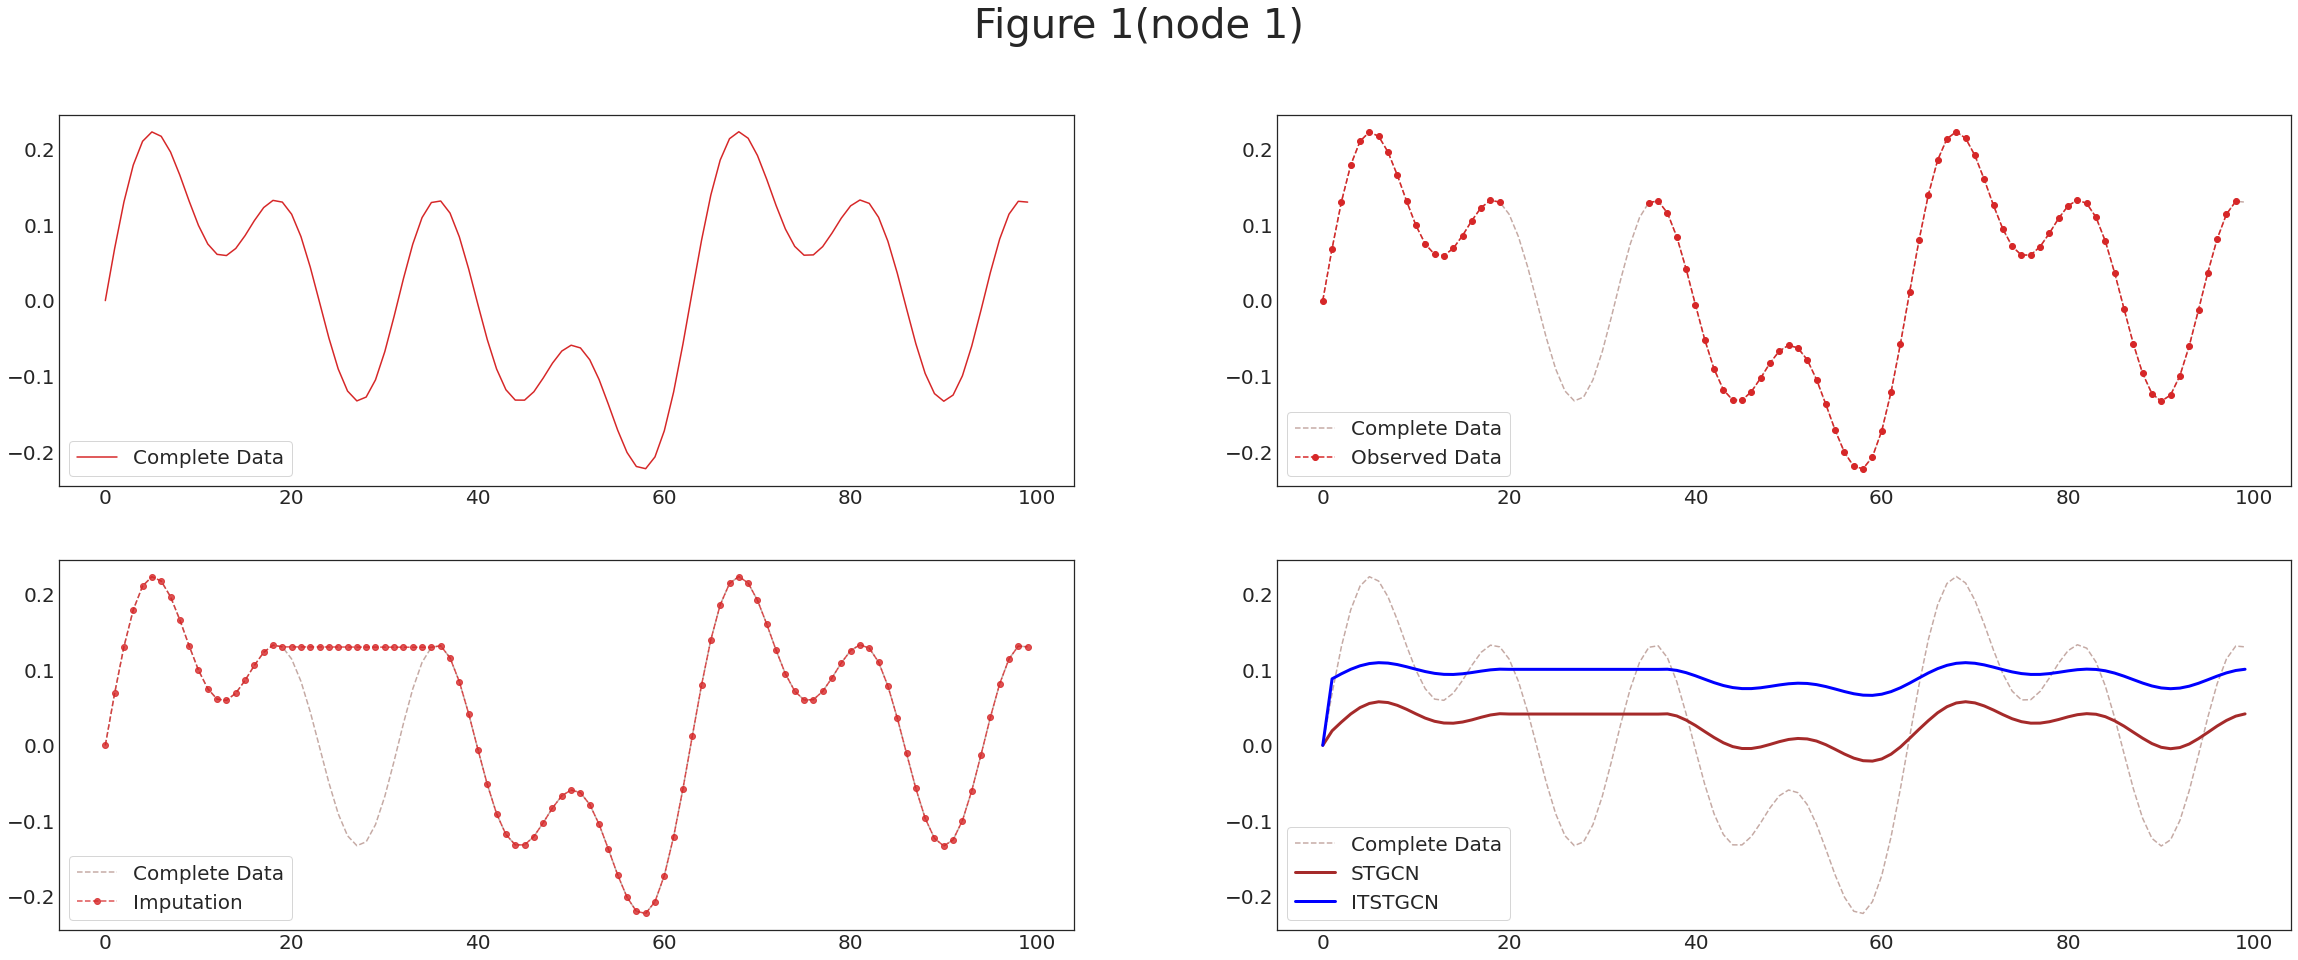

In [570]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_DCRNN.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_DCRNN2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_DCRNN.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_DCRNN2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

In [ ]:
# with plt.style.context('seaborn-white'):
#     # plt.rcParams['font.family'] = 'xkcd'
#     # plt.xkcd(scale=0,length=200)
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
#     fig.suptitle('Figure 1(node 2)',fontsize=40)
#     ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
#     ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
#     ax1.tick_params(axis='y', labelsize=20)
#     ax1.tick_params(axis='x', labelsize=20)
#     ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
#     ax2.plot(torch.tensor(dataset_miss_DCRNN.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
#     ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
#     ax2.tick_params(axis='y', labelsize=20)
#     ax2.tick_params(axis='x', labelsize=20)
#     ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
#     ax3.plot(evtor_DCRNN2.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
#     ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
#     ax3.tick_params(axis='y', labelsize=20)
#     ax3.tick_params(axis='x', labelsize=20)
    
#     ax4.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
#     ax4.plot(evtor_DCRNN.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
#     ax4.plot(evtor_DCRNN2.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
#     # ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, 0.1,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
#     ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
#     ax4.tick_params(axis='y', labelsize=20)
#     ax4.tick_params(axis='x', labelsize=20)

# GConvLSTM

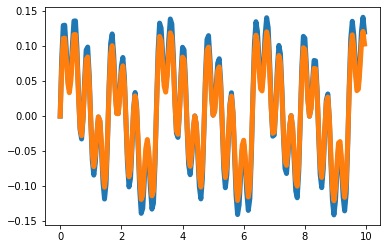

In [36]:
T = 200
t = np.arange(T)/T * 10
x = 0.1*np.sin(2*t)+0.2*np.sin(4*t)+0.1*np.sin(8*t)+0.2*np.sin(16*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
eps_y  = np.random.normal(size=T)*0
x = x*0.35
y = y*0.3
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}
_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1],[1,0]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [37]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [38]:
dataset_GConvLSTM = loader1.get_dataset(lags=1)

In [39]:
mindex = [random.sample(range(0, T), int(T*0.5)),[np.array(list(range(100,120)))]]
dataset_miss_GConvLSTM = itstgcn.miss(dataset_GConvLSTM,mindex,mtype='block')

In [40]:
dataset_padded_cubic_GConvLSTM = itstgcn.padding(dataset_miss_GConvLSTM,interpolation_method='cubic')

In [41]:
lrnr_GConvLSTM = itstgcn.StgcnLearner(dataset_padded_cubic_GConvLSTM)

In [42]:
lrnr_GConvLSTM.learn(filters=8,epoch=50,RecurrentGCN='GConvLSTM')

In [43]:
evtor_GConvLSTM = Eval_csy(lrnr_GConvLSTM,dataset_padded_cubic_GConvLSTM)

In [44]:
lrnr_GConvLSTM2 = itstgcn.ITStgcnLearner(dataset_padded_cubic_GConvLSTM)

In [45]:
lrnr_GConvLSTM2.learn(filters=8,epoch=50,RecurrentGCN='GConvLSTM')

In [46]:
evtor_GConvLSTM2 = Eval_csy(lrnr_GConvLSTM2,dataset_padded_cubic_GConvLSTM)

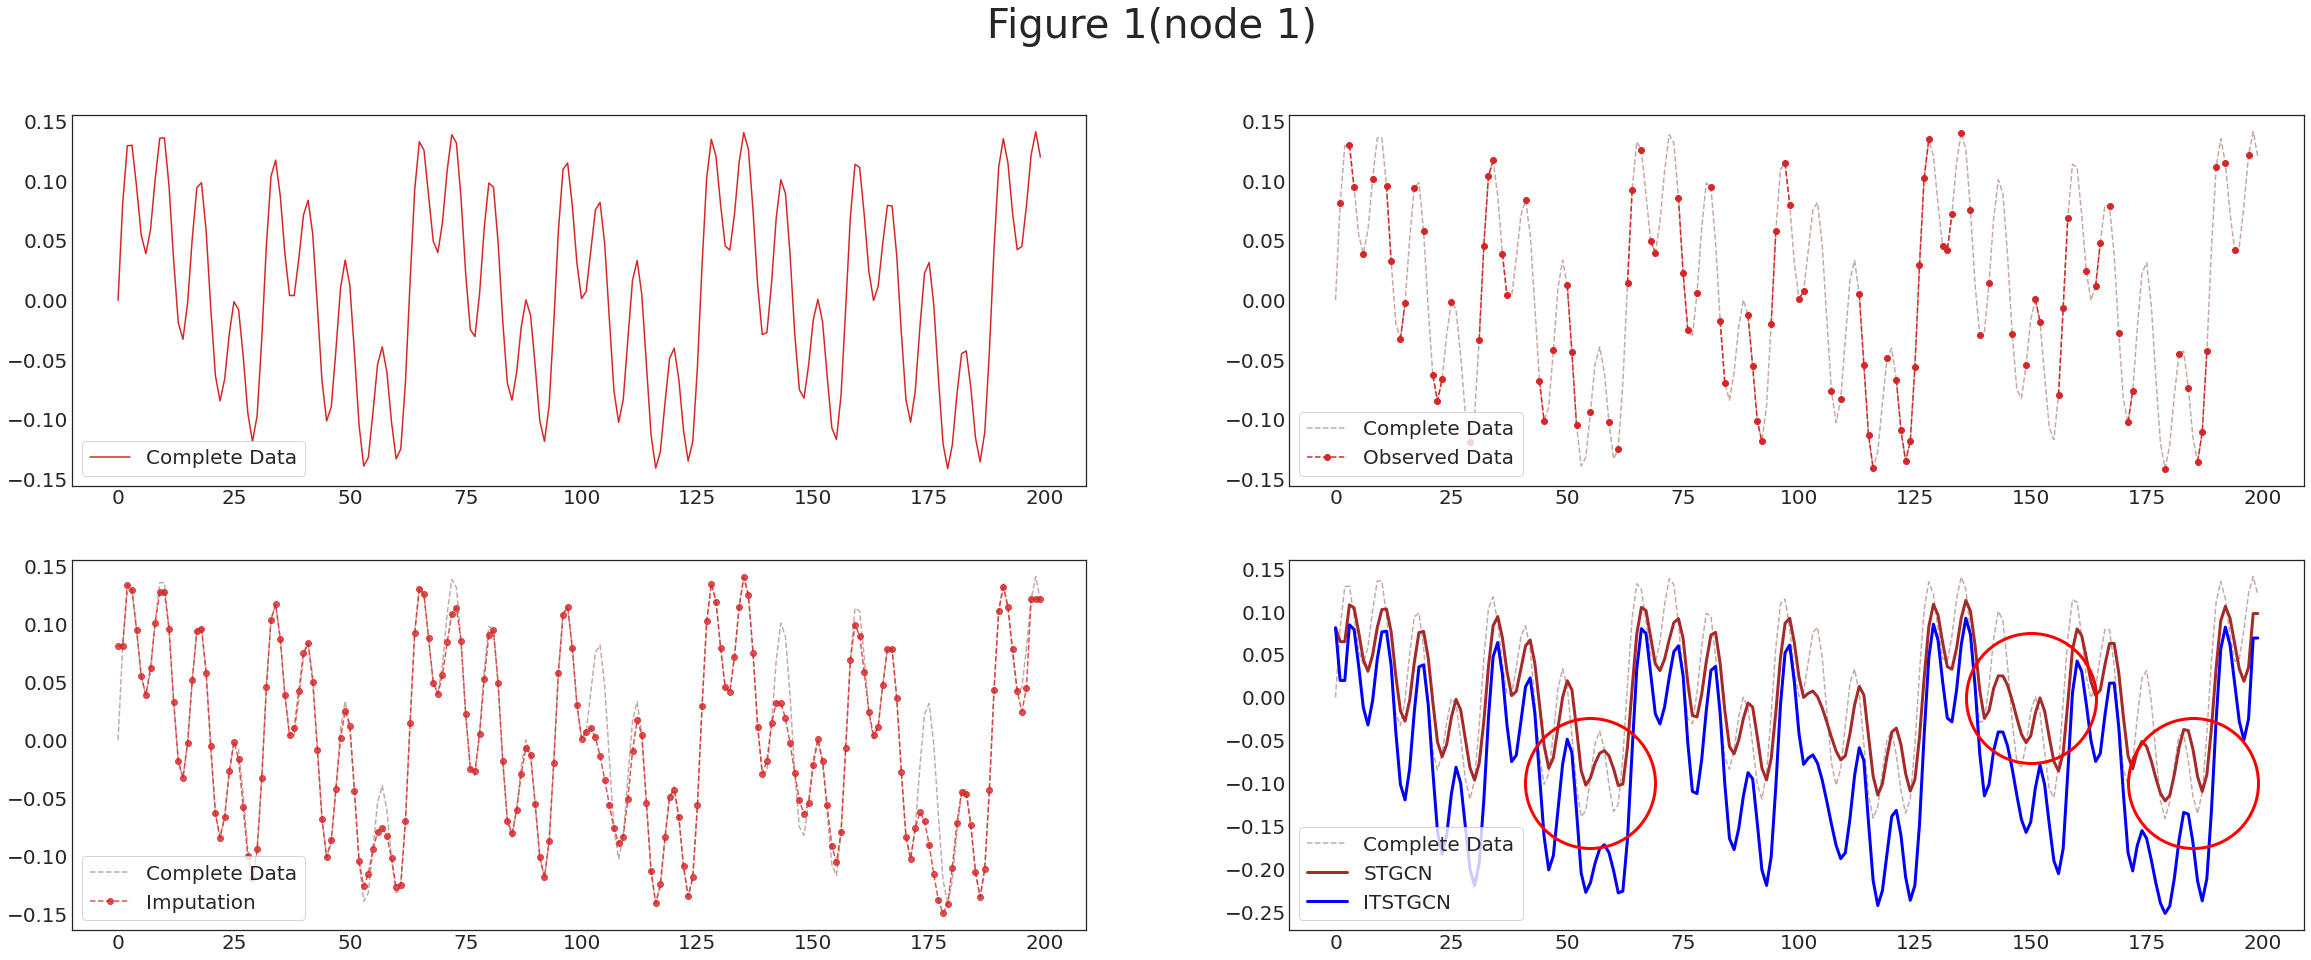

In [47]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_GConvLSTM.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_GConvLSTM2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_GConvLSTM.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_GConvLSTM2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    ax4.plot(55, -0.1, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.plot(150, 0, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.plot(185, -0.1, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

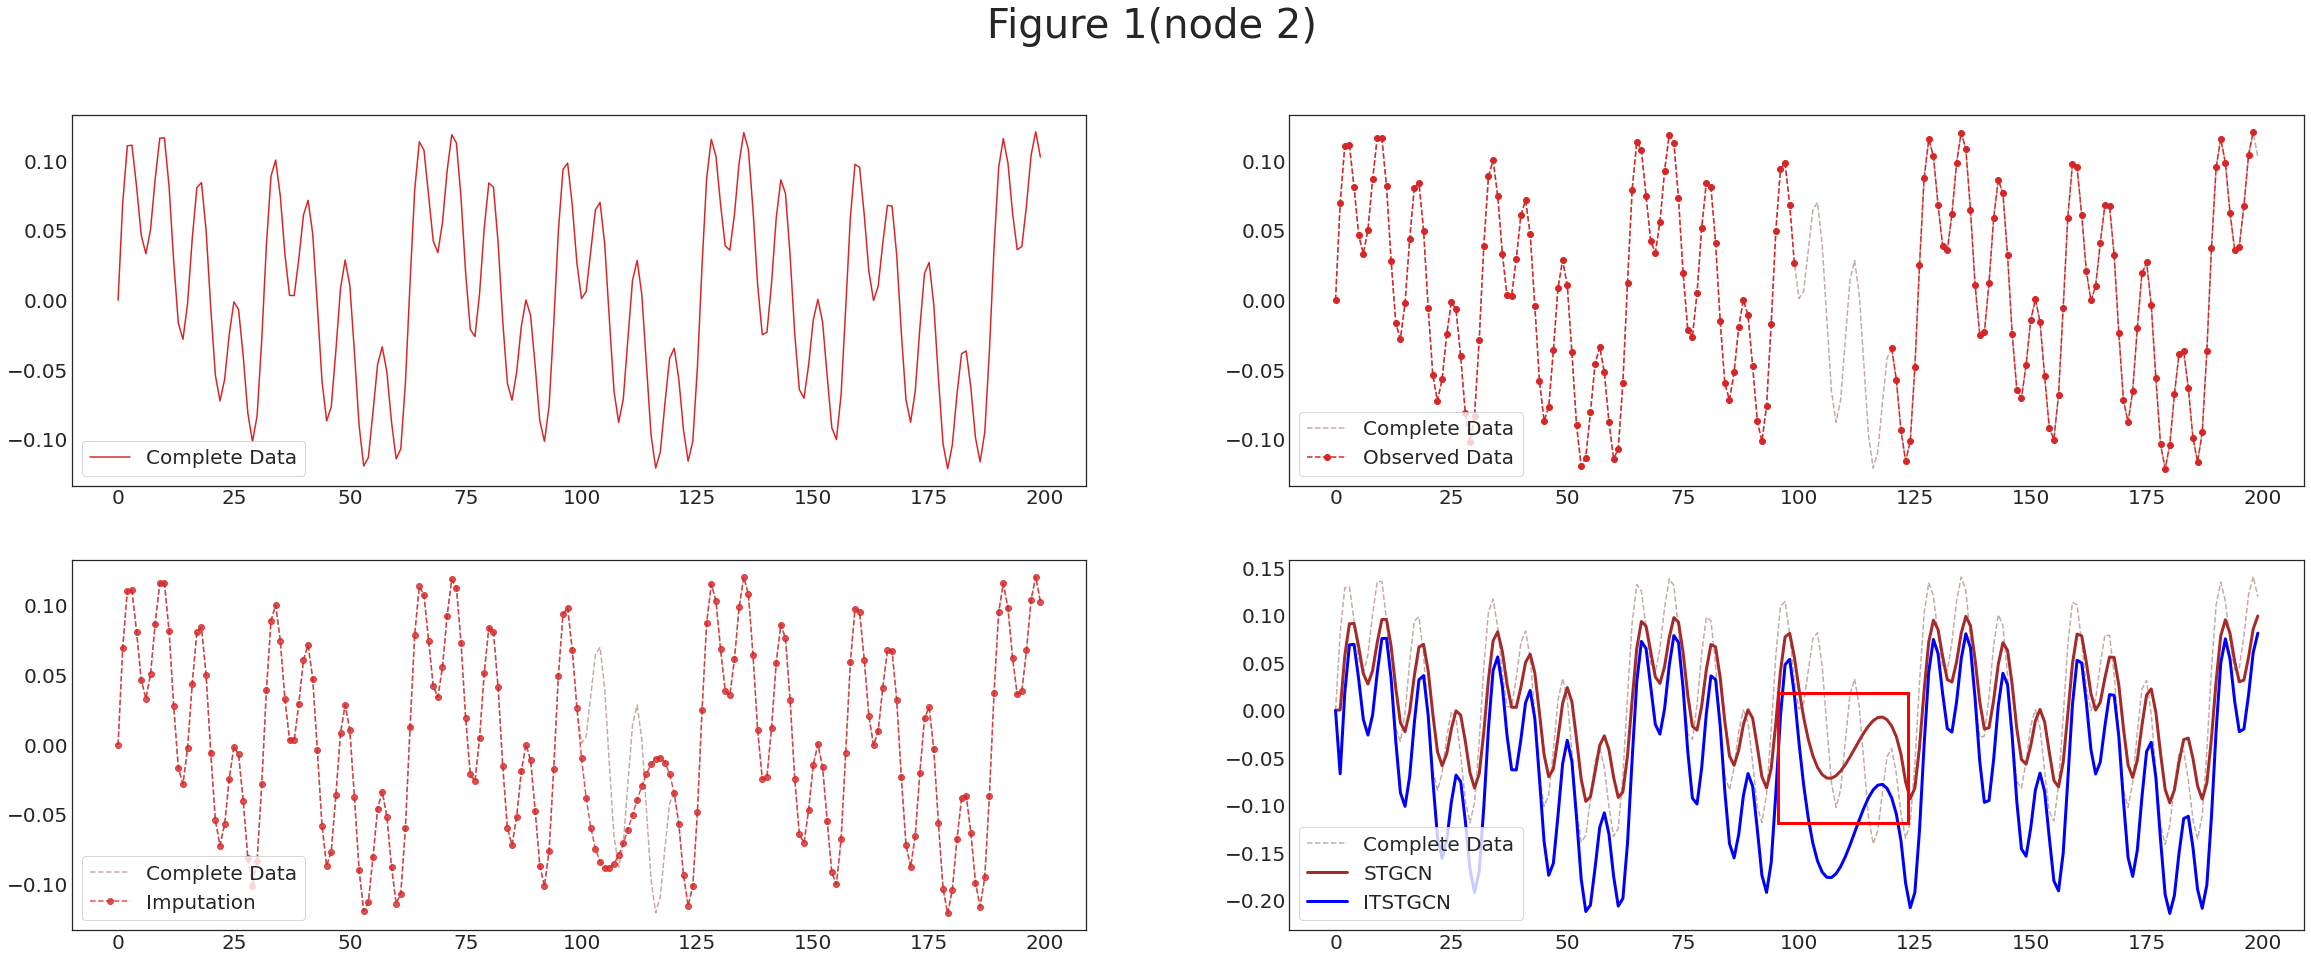

In [48]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_GConvLSTM.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_GConvLSTM2.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_GConvLSTM.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_GConvLSTM2.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, -0.05,'s', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

# MPNNLSTM

In [ ]:
T =300
t = np.arange(T)/T * 5

x = 0.1*np.sin(2*t)+0.1*np.sin(4*t)+0.1*np.sin(8*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
for i in range(2,T):
    y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.5*np.cos(0.4*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x
y = y
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [ ]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [ ]:
dataset_MPNNLSTM = loader1.get_dataset(lags=1)

In [ ]:
mindex = [random.sample(range(0, T), int(T*0.5)),[np.array(list(range(100,120)))]]
dataset_miss_MPNNLSTM = itstgcn.miss(dataset_MPNNLSTM,mindex,mtype='block')

In [ ]:
dataset_padded_cubic_MPNNLSTM = itstgcn.padding(dataset_miss_MPNNLSTM,interpolation_method='cubic')

In [ ]:
lrnr_MPNNLSTM = itstgcn.StgcnLearner(dataset_padded_cubic_MPNNLSTM)

In [ ]:
lrnr_MPNNLSTM.learn(filters=8,epoch=50,RecurrentGCN='MPNNLSTM')

In [ ]:
evtor_MPNNLSTM = Eval_csy(lrnr_MPNNLSTM,dataset_padded_cubic_MPNNLSTM)

In [ ]:
lrnr_MPNNLSTM_2 = itstgcn.ITStgcnLearner(dataset_padded_cubic_MPNNLSTM)

In [ ]:
lrnr_MPNNLSTM_2.learn(filters=8,epoch=50,RecurrentGCN='MPNNLSTM')

In [ ]:
evtor_MPNNLSTM_2 = Eval_csy(lrnr_MPNNLSTM_2,dataset_padded_cubic_MPNNLSTM)

In [ ]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_MPNNLSTM.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_MPNNLSTM_2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_MPNNLSTM.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_MPNNLSTM_2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

In [ ]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_MPNNLSTM.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_MPNNLSTM_2.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_MPNNLSTM.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_MPNNLSTM_2.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, 0.01,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

# TGCN

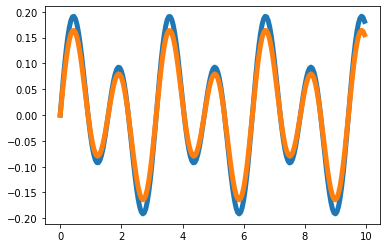

In [62]:
T = 200
t = np.arange(T)/T * 10
x = 0.2*np.sin(2*t)+0.4*np.sin(4*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
eps_y  = np.random.normal(size=T)*0
x = x*0.35
y = y*0.3
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1],[1,0]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}

df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [63]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [64]:
dataset_TGCN = loader1.get_dataset(lags=1)

In [65]:
mindex = [random.sample(range(0, T), int(T*0.5)),[np.array(list(range(70,120)))]]
dataset_miss_TGCN = itstgcn.miss(dataset_TGCN,mindex,mtype='block')

In [66]:
dataset_padded_cubic_TGCN = itstgcn.padding(dataset_miss_TGCN,interpolation_method='cubic')

In [67]:
lrnr_TGCN = itstgcn.StgcnLearner(dataset_padded_cubic_TGCN)

In [68]:
lrnr_TGCN.learn(filters=8,epoch=50,RecurrentGCN='TGCN')

In [69]:
evtor_TGCN = Eval_csy(lrnr_TGCN,dataset_padded_cubic_TGCN)

In [70]:
lrnr_TGCN2 = itstgcn.ITStgcnLearner(dataset_padded_cubic_TGCN)

In [71]:
lrnr_TGCN2.learn(filters=8,epoch=50,RecurrentGCN='TGCN')

In [72]:
evtor_TGCN2 = Eval_csy(lrnr_TGCN2,dataset_padded_cubic_TGCN)

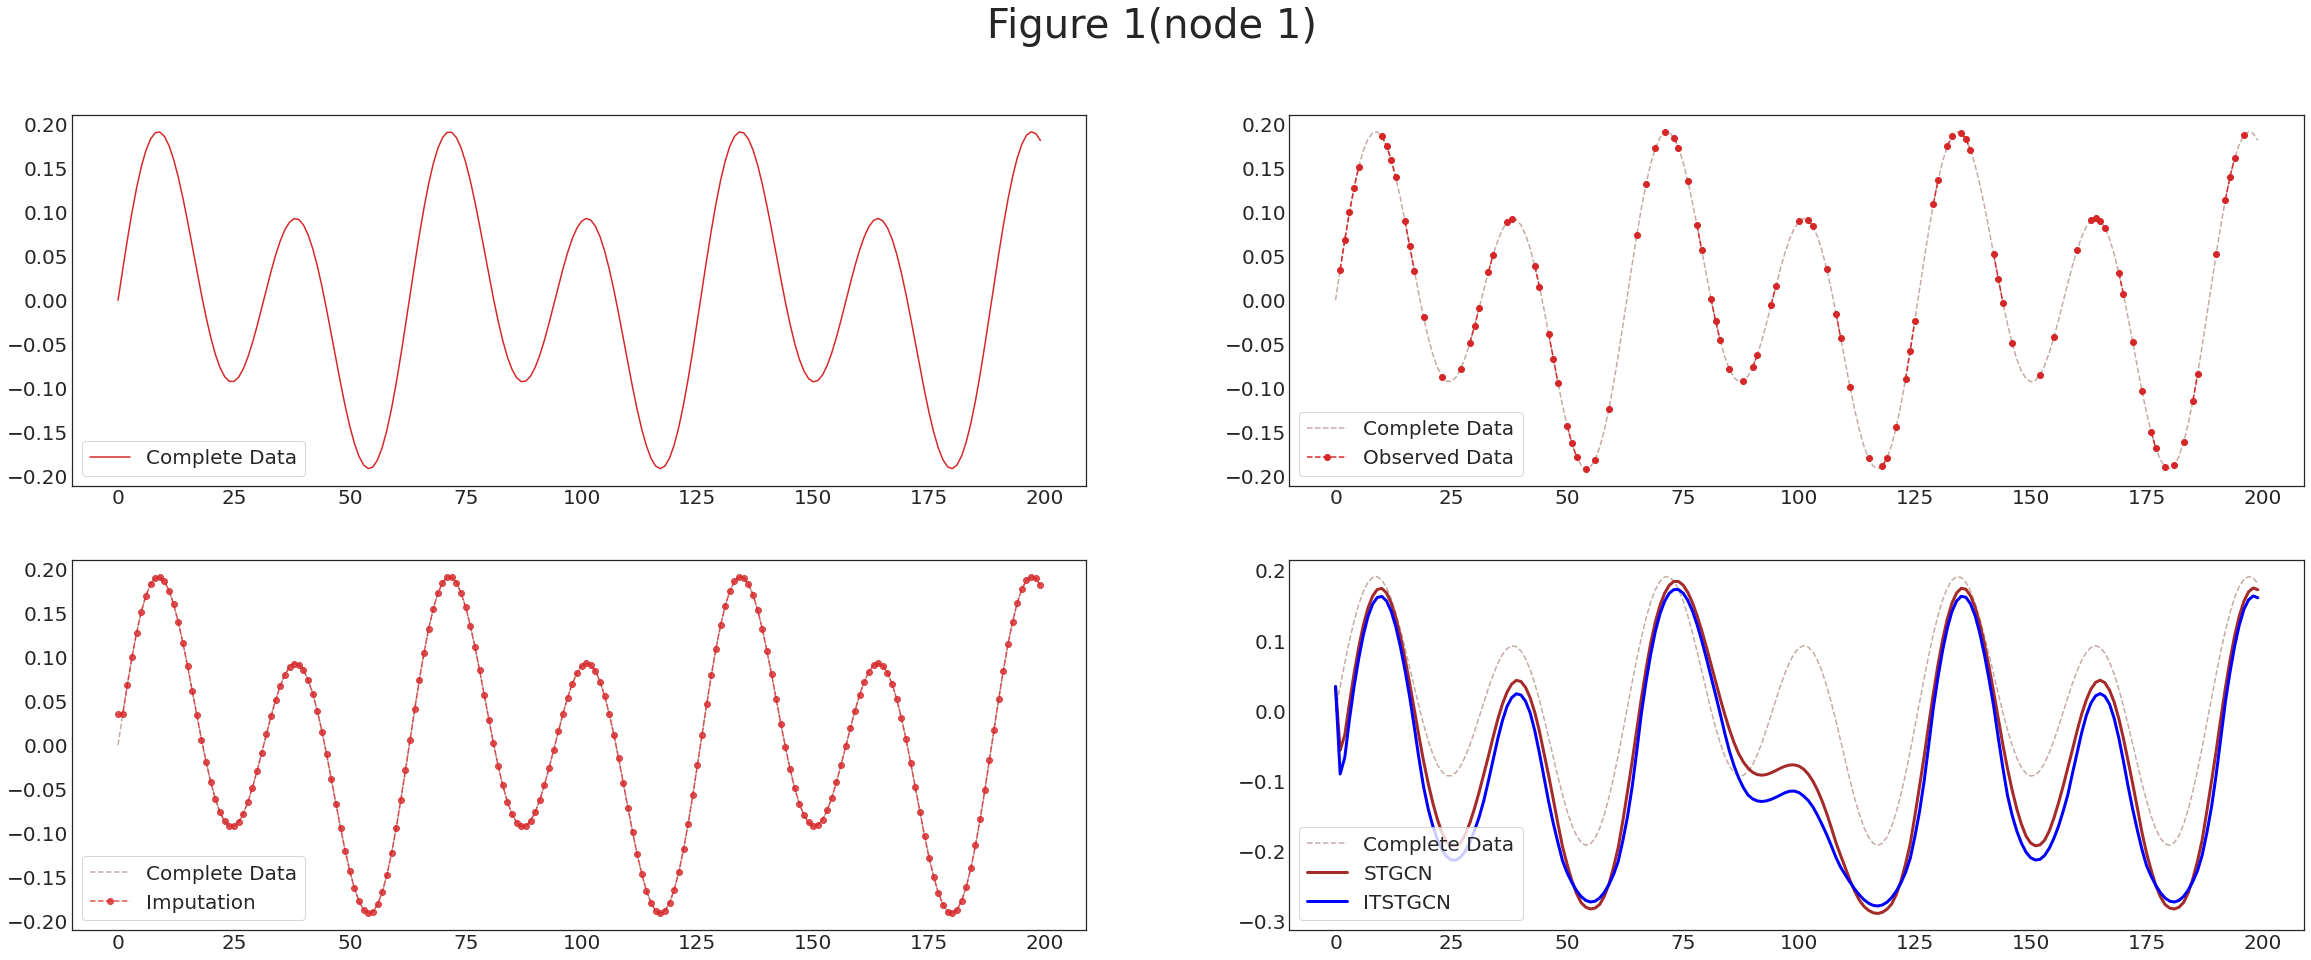

In [73]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_TGCN.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_TGCN2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_TGCN.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_TGCN2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

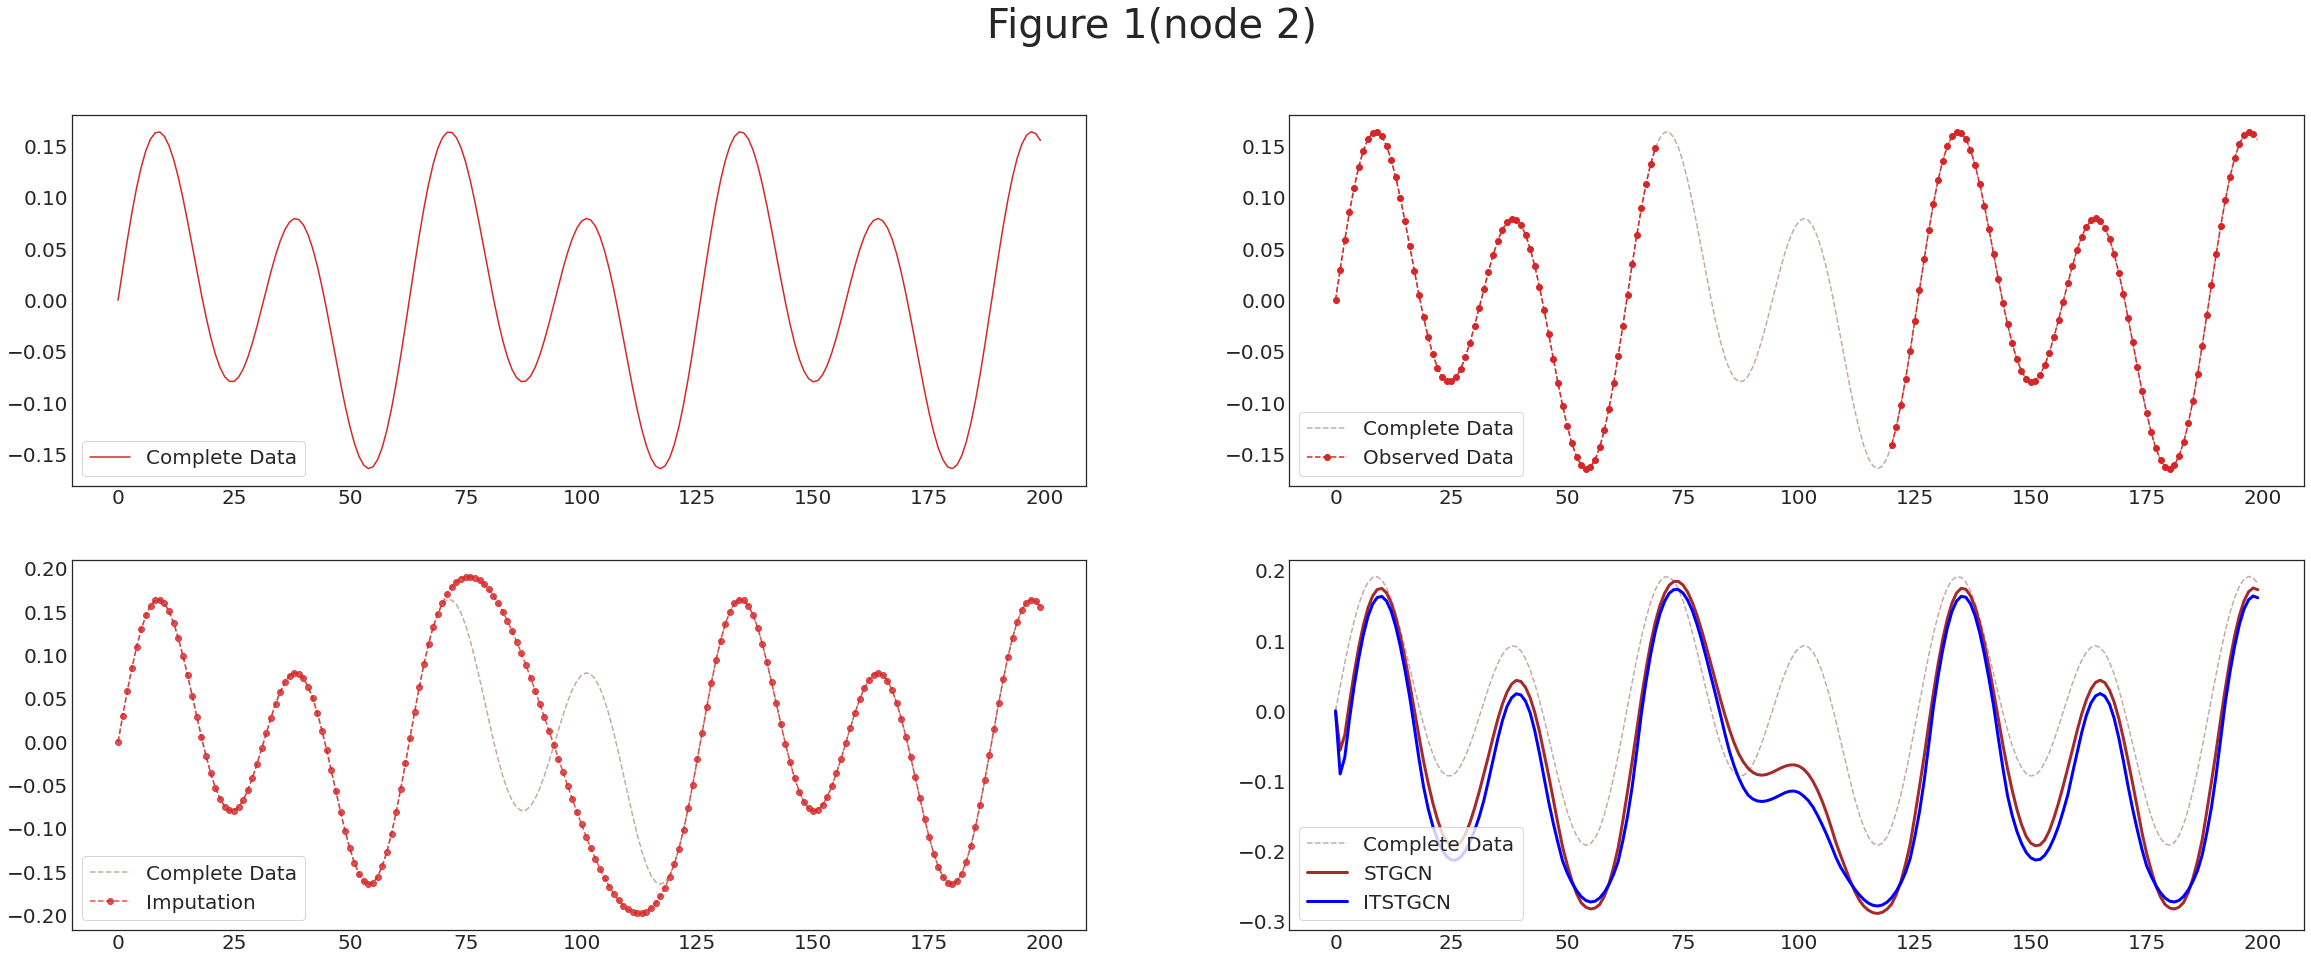

In [74]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_TGCN.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_TGCN2.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_TGCN.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_TGCN2.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, 0.01,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

# EvolveGCNO

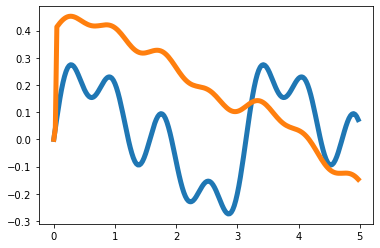

In [105]:
T = 200
t = np.arange(T)/T * 5

x = 0.2*np.sin(2*t)+0.1*np.sin(4*t)+0.1*np.sin(8*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
for i in range(2,T):
    y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.4*np.cos(0.4*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x
y = y
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [106]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [107]:
dataset_EvolveGCNO = loader1.get_dataset(lags=1)

In [ ]:
mindex = [random.sample(range(0, T), int(T*0.7)),[np.array(list(range(75,100)))]]
dataset_miss_EvolveGCNO= itstgcn.miss(dataset_EvolveGCNO,mindex,mtype='block')

In [ ]:
dataset_padded_cubic_EvolveGCNO = itstgcn.padding(dataset_miss_EvolveGCNO,interpolation_method='cubic')

In [ ]:
lrnr_EvolveGCNO= itstgcn.StgcnLearner(dataset_padded_cubic_EvolveGCNO)

In [ ]:
lrnr_EvolveGCNO.learn(filters=2,epoch=50,lr=0.01,RecurrentGCN='EvolveGCNO')

In [ ]:
evtor_EvolveGCNO = Eval_csy(lrnr_EvolveGCNO,dataset_padded_cubic_EvolveGCNO)

In [ ]:
lrnr_EvolveGCNO2 = itstgcn.ITStgcnLearner(dataset_padded_cubic_EvolveGCNO)

In [ ]:
lrnr_EvolveGCNO2.learn(filters=2,epoch=50,lr=0.01,RecurrentGCN='EvolveGCNO')

In [ ]:
evtor_EvolveGCNO2 = Eval_csy(lrnr_EvolveGCNO2,dataset_padded_cubic_EvolveGCNO)

In [ ]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_EvolveGCNO.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_EvolveGCNO2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_EvolveGCNO.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_EvolveGCNO2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

In [ ]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_EvolveGCNO.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_EvolveGCNO2.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['xer'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_EvolveGCNO.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_EvolveGCNO2.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, 0.01,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

# GCLSTM

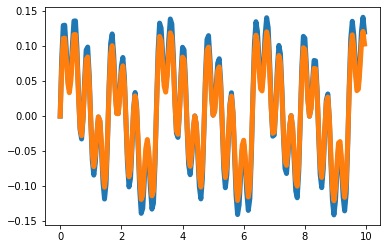

In [138]:
T = 200
t = np.arange(T)/T * 10
x = 0.1*np.sin(2*t)+0.2*np.sin(4*t)+0.1*np.sin(8*t)+0.2*np.sin(16*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
eps_y  = np.random.normal(size=T)*0
x = x*0.35
y = y*0.3
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}
_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1],[1,0]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [139]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [140]:
dataset_GCLSTM = loader1.get_dataset(lags=1)

In [141]:
mindex = [random.sample(range(0, T), int(T*0.7)),[np.array(list(range(70,120)))]]
dataset_miss_GCLSTM = itstgcn.miss(dataset_GCLSTM,mindex,mtype='block')

In [142]:
dataset_padded_cubic_GCLSTM = itstgcn.padding(dataset_miss_GCLSTM,interpolation_method='cubic')

In [143]:
lrnr_GCLSTM = itstgcn.StgcnLearner(dataset_padded_cubic_GCLSTM)

In [144]:
lrnr_GCLSTM.learn(filters=8,epoch=50,lr=0.01,RecurrentGCN='GCLSTM')

In [145]:
evtor_GCLSTM = Eval_csy(lrnr_GCLSTM,dataset_padded_cubic_GCLSTM)

In [146]:
lrnr_GCLSTM2 = itstgcn.ITStgcnLearner(dataset_padded_cubic_GCLSTM)

In [147]:
lrnr_GCLSTM2.learn(filters=8,epoch=50,lr=0.01,RecurrentGCN='GCLSTM')

In [148]:
evtor_GCLSTM2 = Eval_csy(lrnr_GCLSTM2,dataset_padded_cubic_GCLSTM)

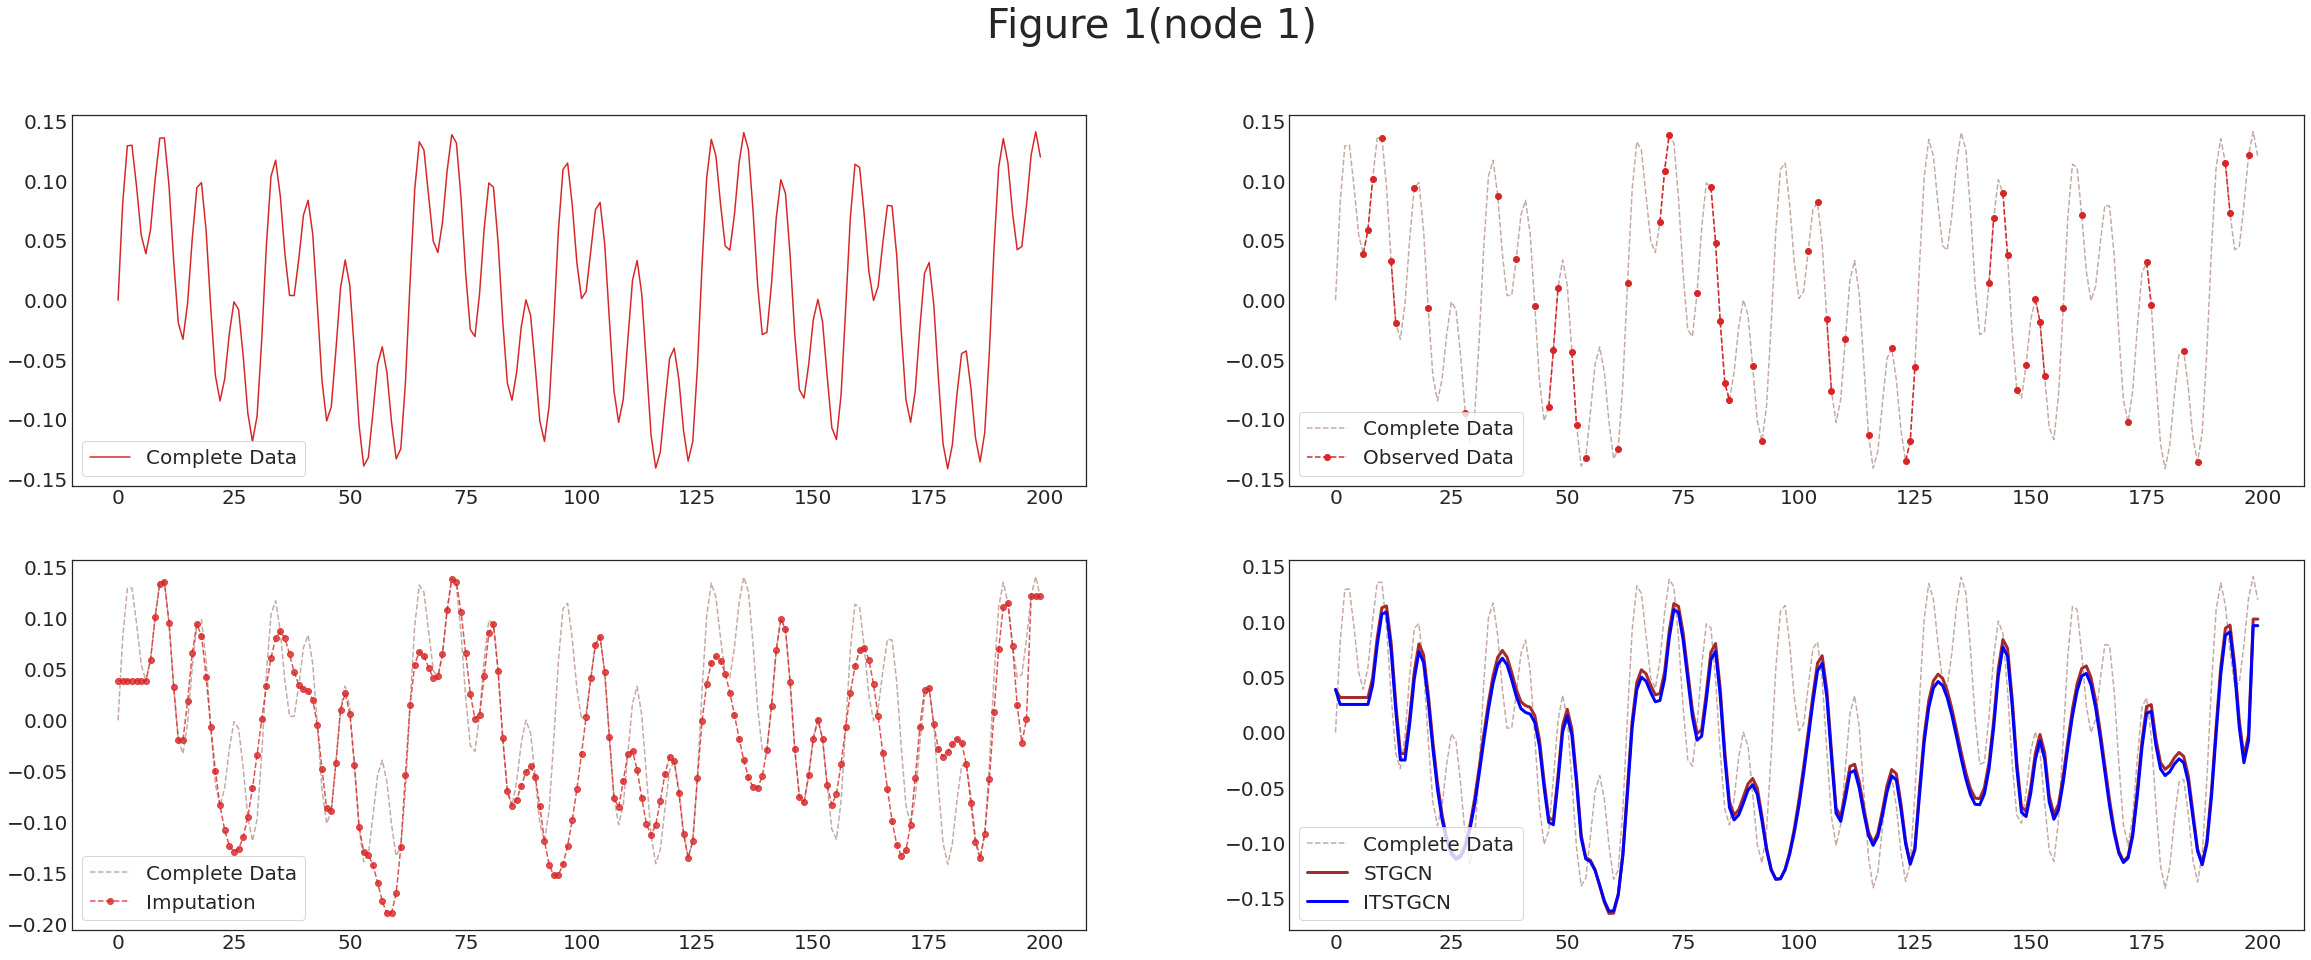

In [149]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_GCLSTM.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_GCLSTM2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_GCLSTM.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_GCLSTM2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, -0.1, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, -0.1, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

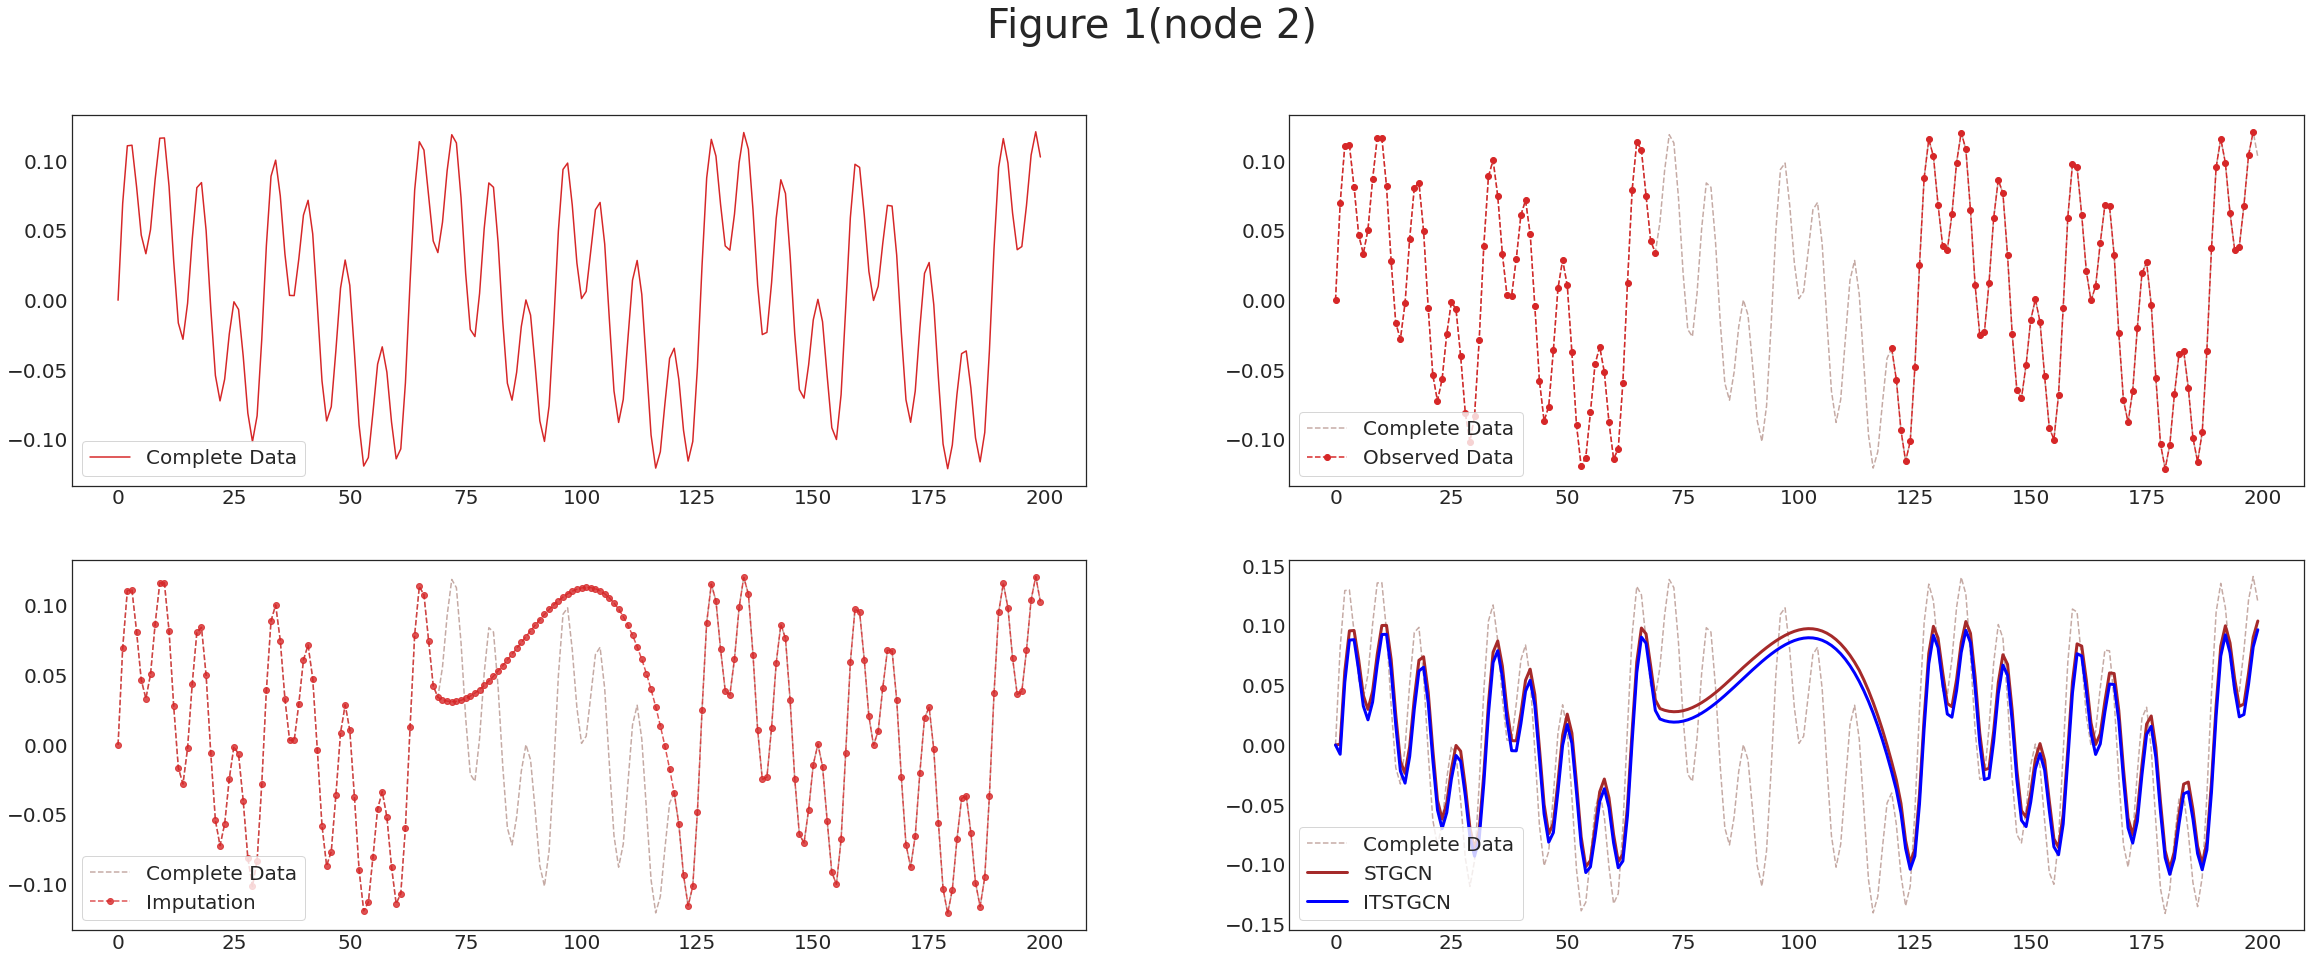

In [152]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_GCLSTM.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_GCLSTM2.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_GCLSTM.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_GCLSTM2.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, -0.05,'s', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

# LRGCN

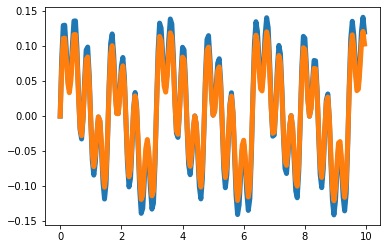

In [153]:
T = 200
t = np.arange(T)/T * 10
x = 0.1*np.sin(2*t)+0.2*np.sin(4*t)+0.1*np.sin(8*t)+0.2*np.sin(16*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
eps_y  = np.random.normal(size=T)*0
x = x*0.35
y = y*0.3
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}
_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1],[1,0]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [154]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [155]:
dataset_LRGCN = loader1.get_dataset(lags=1)

In [156]:
mindex = [random.sample(range(0, T), int(T*0.7)),[np.array(list(range(100,120)))]]
dataset_miss_LRGCN = itstgcn.miss(dataset_LRGCN,mindex,mtype='block')

In [157]:
dataset_padded_cubic_LRGCN = itstgcn.padding(dataset_miss_LRGCN,interpolation_method='cubic')

In [158]:
lrnr_LRGCN = itstgcn.StgcnLearner(dataset_padded_cubic_LRGCN)

In [159]:
lrnr_LRGCN.learn(filters=8,epoch=50,lr=0.01,RecurrentGCN='LRGCN')

In [160]:
evtor_LRGCN = Eval_csy(lrnr_LRGCN,dataset_padded_cubic_LRGCN)

In [161]:
lrnr_LRGCN2 = itstgcn.ITStgcnLearner(dataset_padded_cubic_LRGCN)

In [162]:
lrnr_LRGCN2.learn(filters=8,epoch=50,lr=0.01,RecurrentGCN='LRGCN')

In [163]:
evtor_LRGCN2 = Eval_csy(lrnr_LRGCN2,dataset_padded_cubic_LRGCN)

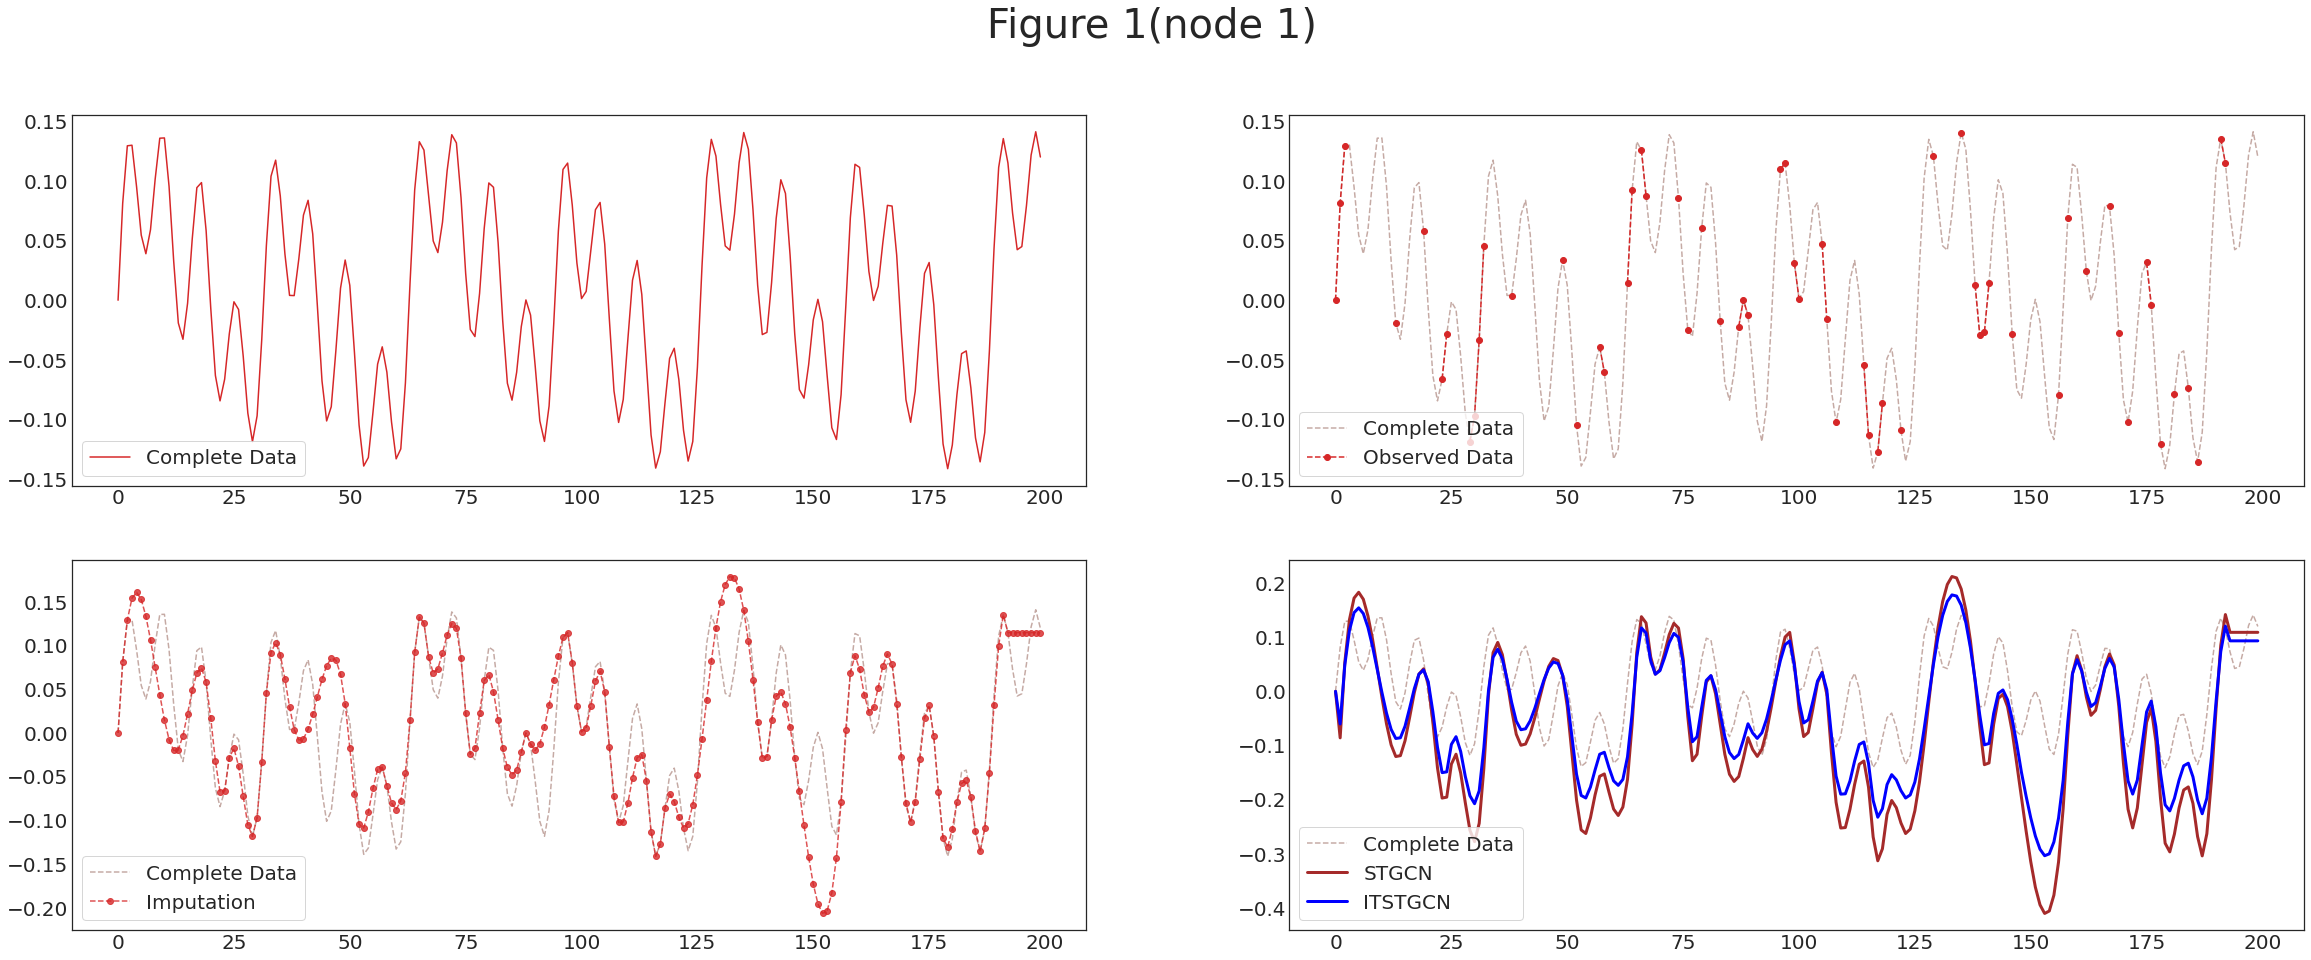

In [166]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_LRGCN.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_LRGCN2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_LRGCN.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_LRGCN2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, -0.1, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, -0.1, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

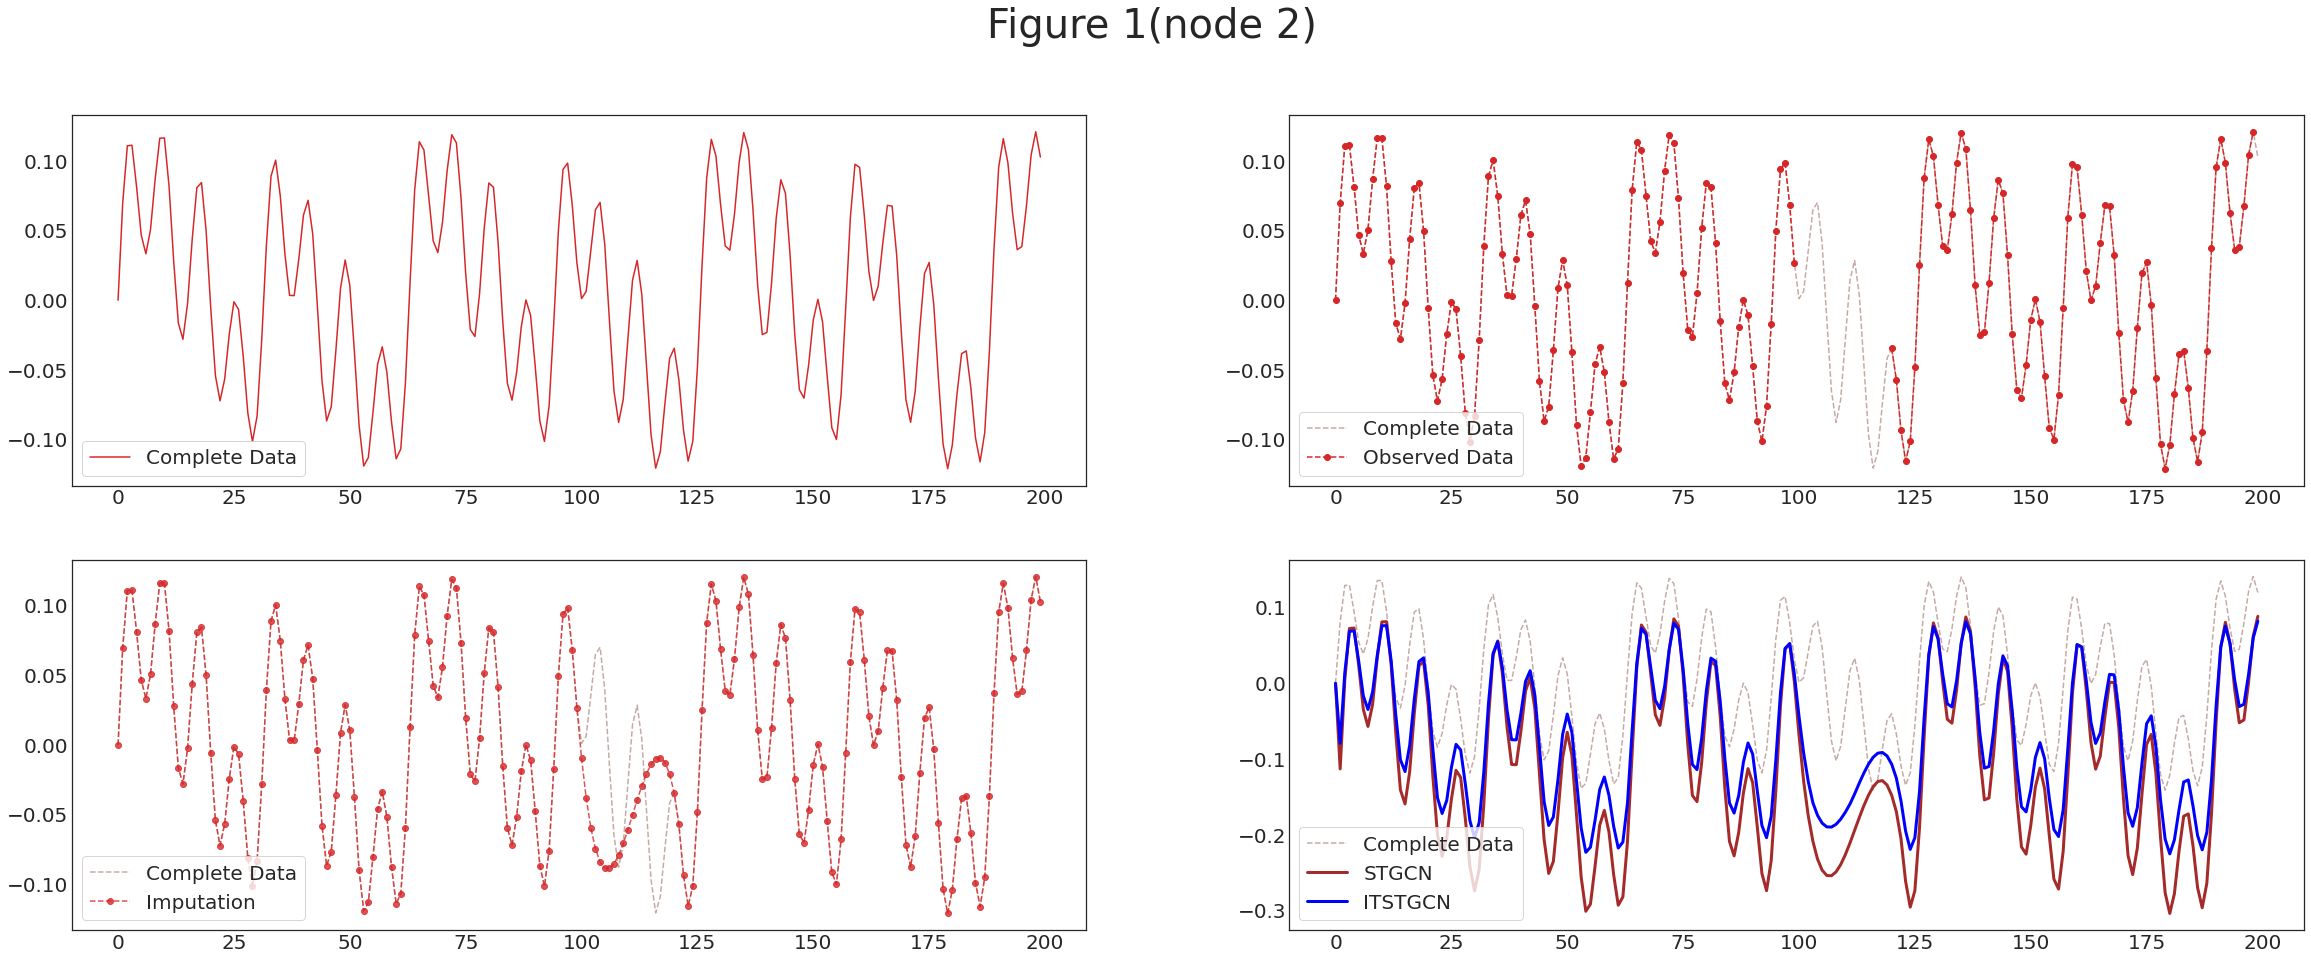

In [167]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_LRGCN.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_LRGCN2.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_LRGCN.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_LRGCN2.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, -0.05,'s', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

# EvolveGCNH

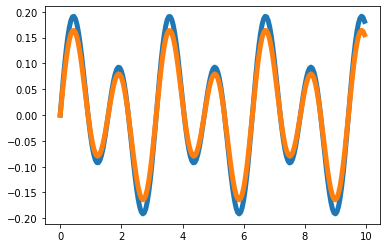

In [189]:
T = 200
t = np.arange(T)/T * 10
x = 0.2*np.sin(2*t)+0.4*np.sin(4*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
eps_y  = np.random.normal(size=T)*0
x = x*0.35
y = y*0.3
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1],[1,0]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}

df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [190]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [191]:
dataset_EvolveGCNH = loader1.get_dataset(lags=1)

In [192]:
mindex = [random.sample(range(0, T), int(T*0.7)),[np.array(list(range(70,120)))]]
dataset_miss_EvolveGCNH = itstgcn.miss(dataset_EvolveGCNH,mindex,mtype='block')

In [193]:
dataset_padded_cubic_EvolveGCNH = itstgcn.padding(dataset_miss_EvolveGCNH,interpolation_method='cubic')

In [194]:
lrnr_EvolveGCNH = itstgcn.StgcnLearner(dataset_padded_cubic_EvolveGCNH)

In [195]:
lrnr_EvolveGCNH.learn(filters=1,epoch=5,lr=0.01,RecurrentGCN='EvolveGCNH')

In [196]:
evtor_EvolveGCNH = Eval_csy(lrnr_EvolveGCNH,dataset_padded_cubic_EvolveGCNH)

In [197]:
lrnr_EvolveGCNH2 = itstgcn.ITStgcnLearner(dataset_padded_cubic_EvolveGCNH)

In [198]:
lrnr_EvolveGCNH2.learn(filters=1,epoch=5,lr=0.01,RecurrentGCN='EvolveGCNH')

In [199]:
evtor_EvolveGCNH2 = Eval_csy(lrnr_EvolveGCNH2,dataset_padded_cubic_EvolveGCNH)

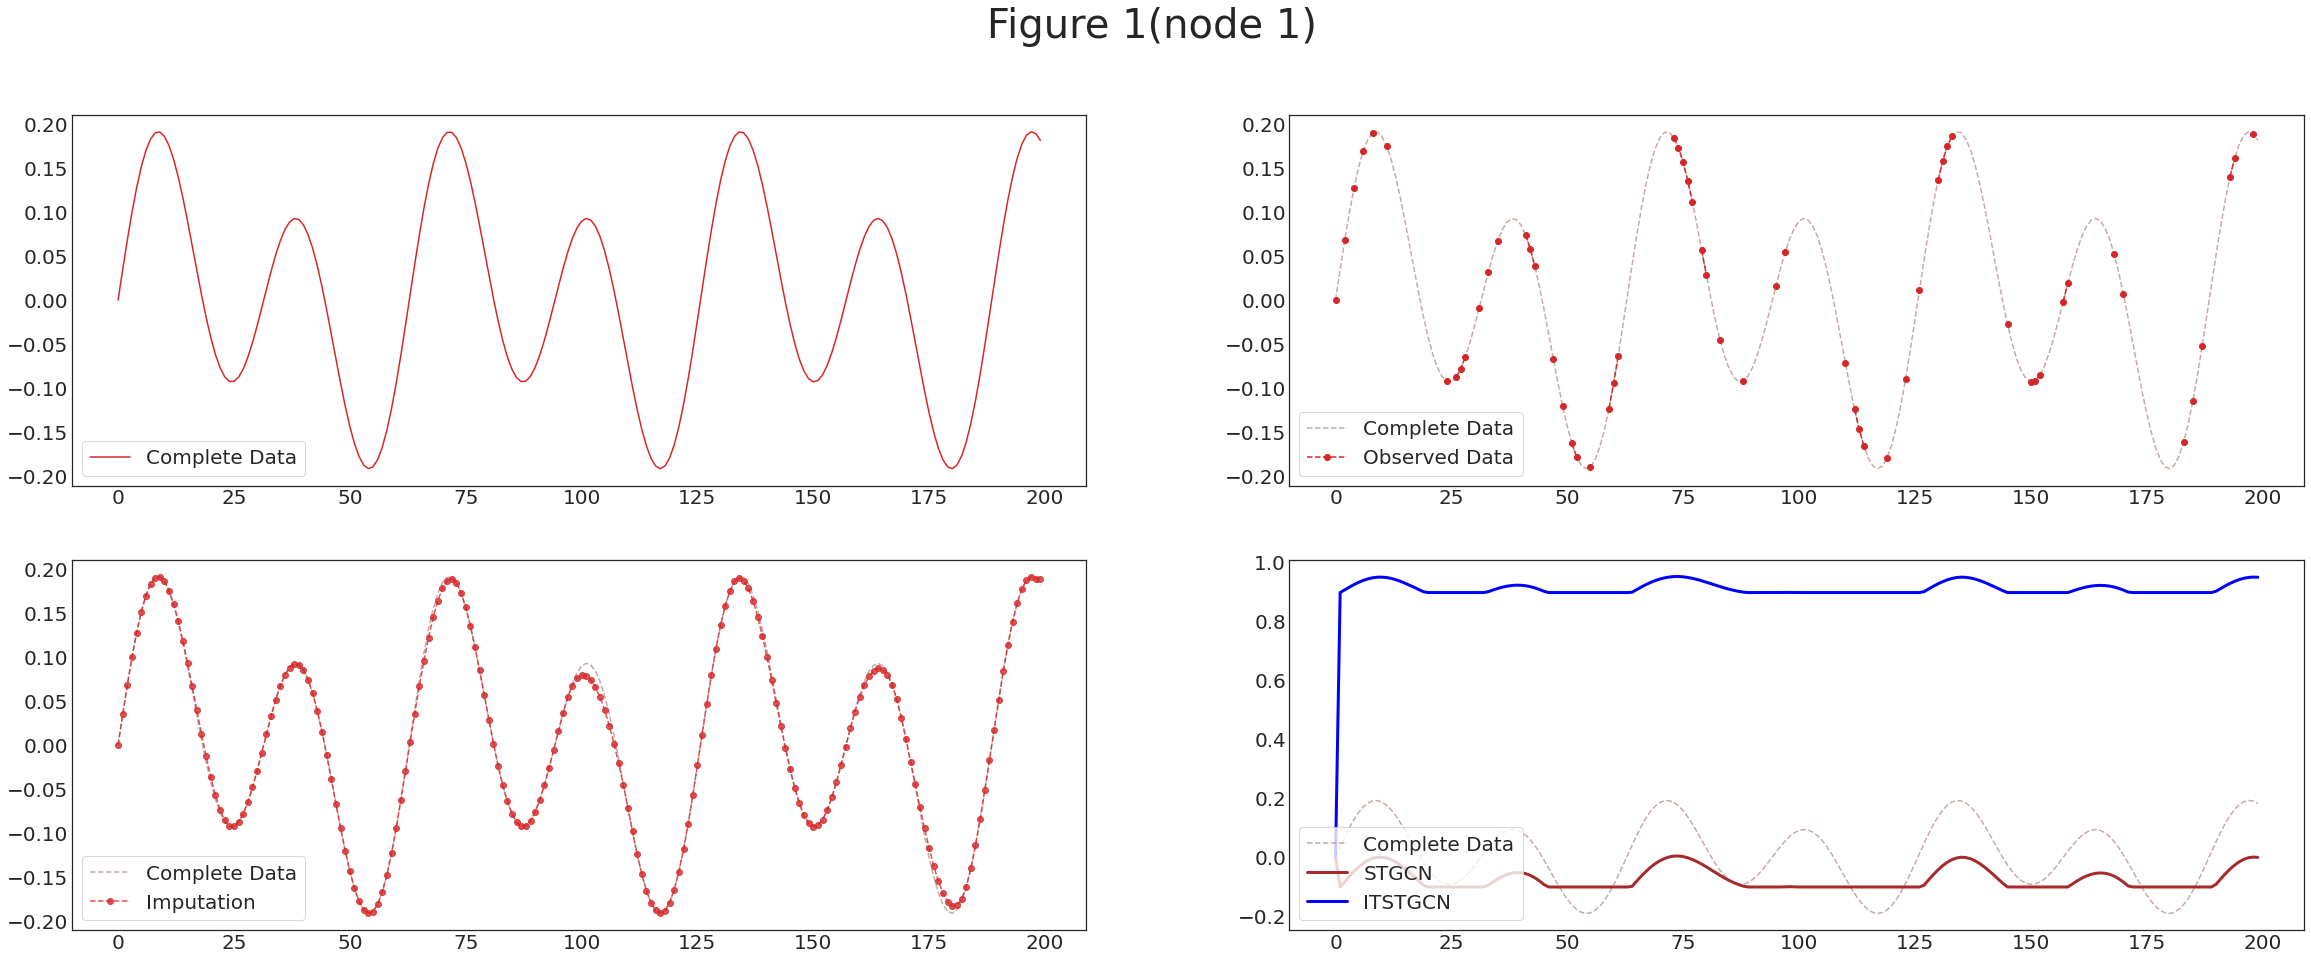

In [200]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_EvolveGCNH.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_EvolveGCNH2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_EvolveGCNH.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_EvolveGCNH2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, -0.1, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, -0.1, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

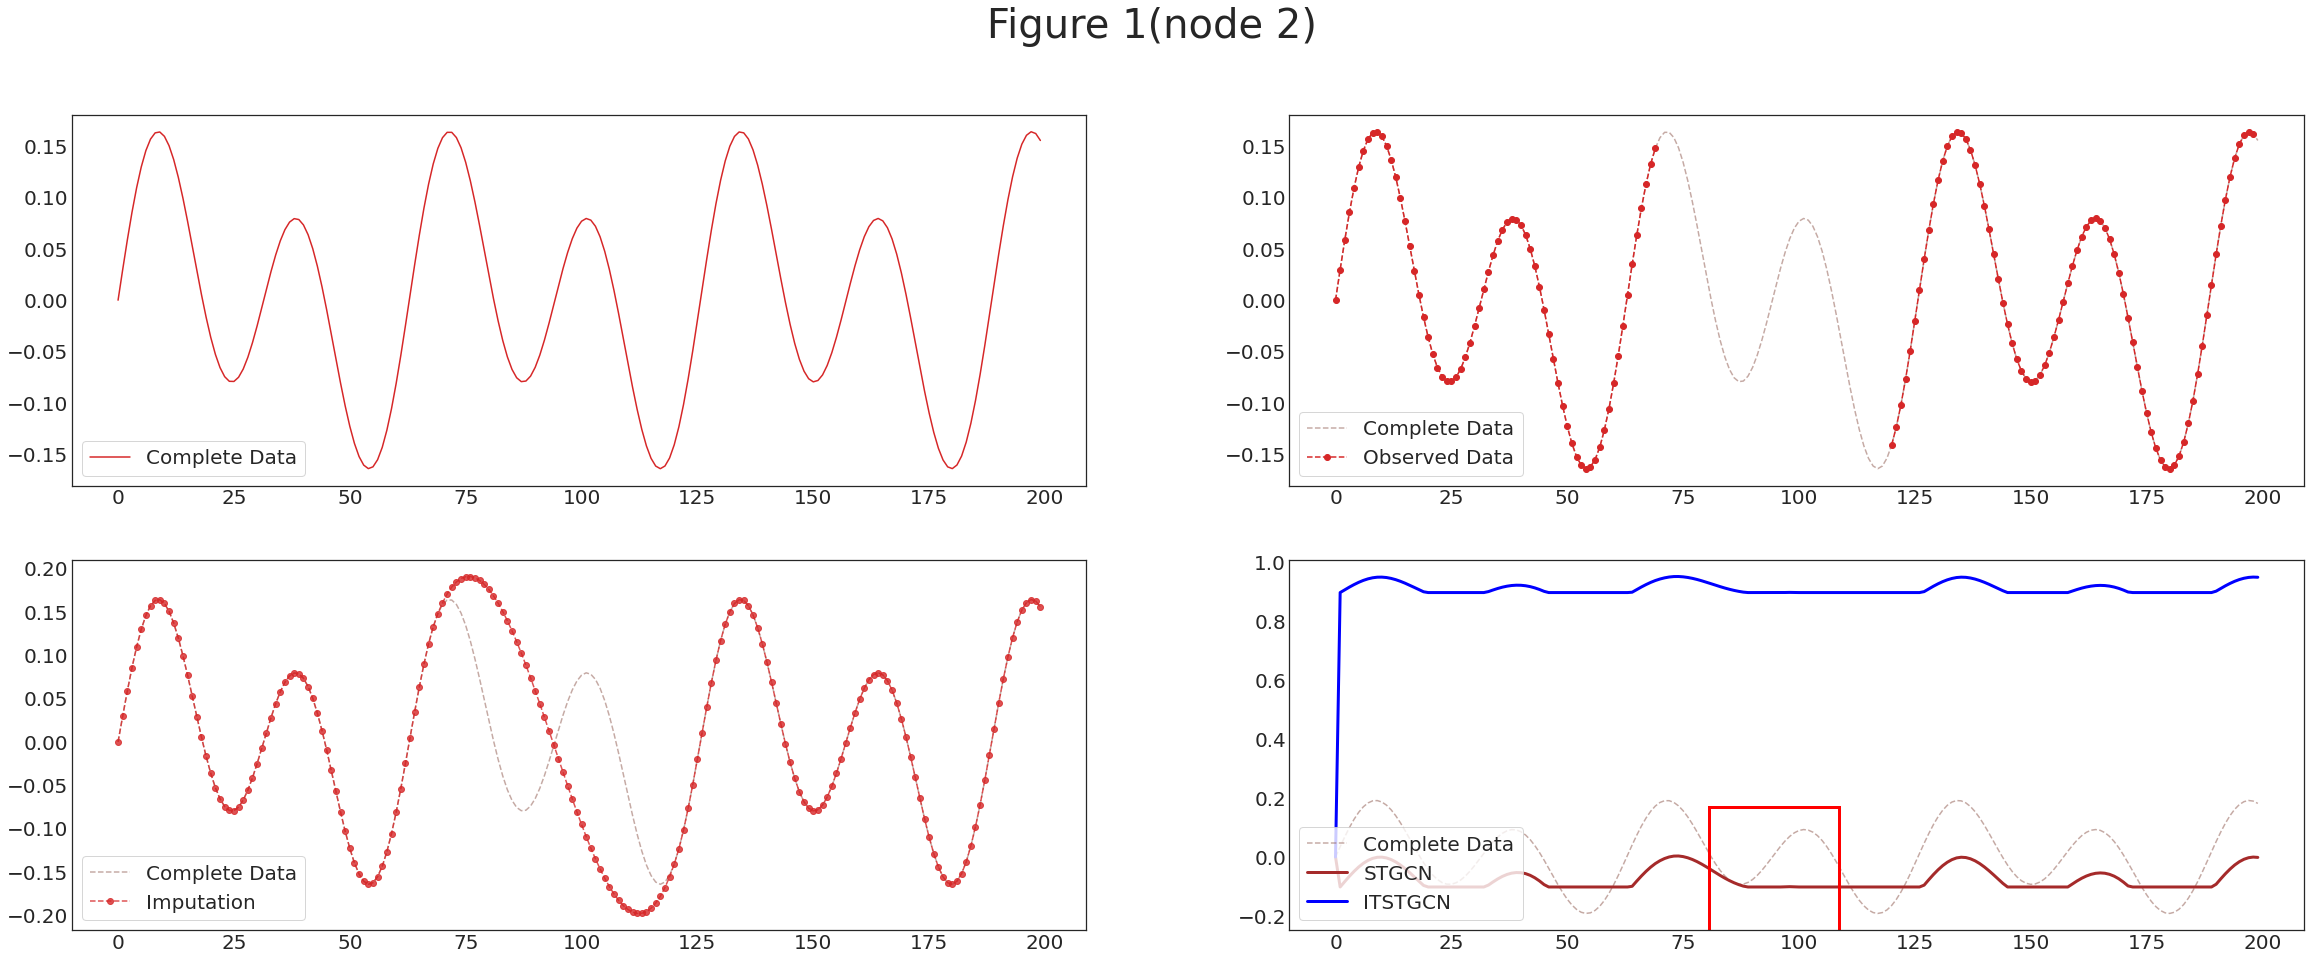

In [201]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_EvolveGCNH.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_EvolveGCNH2.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_EvolveGCNH.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_EvolveGCNH2.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, -0.05,'s', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

# DyGrEncoder

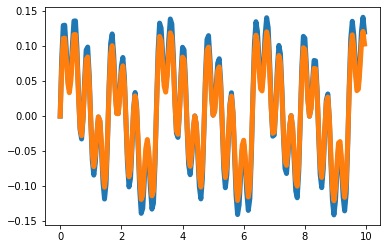

In [394]:
T = 200
t = np.arange(T)/T * 10
x = 0.1*np.sin(2*t)+0.2*np.sin(4*t)+0.1*np.sin(8*t)+0.2*np.sin(16*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
eps_y  = np.random.normal(size=T)*0
x = x*0.35
y = y*0.3
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}
_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1],[1,0]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [9]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [10]:
dataset_DyGrEncoder = loader1.get_dataset(lags=1)

In [11]:
mindex = [random.sample(range(0, T), int(T*0.5)),[np.array(list(range(100,120)))]]
dataset_miss_DyGrEncoder = itstgcn.miss(dataset_DyGrEncoder,mindex,mtype='block')

/home/csy/Dropbox/blog/posts/GCN/itstgcn/utils.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/torch/csrc/utils/tensor_new.cpp:245.)


In [12]:
dataset_padded_cubic_DyGrEncoder = itstgcn.padding(dataset_miss_DyGrEncoder,interpolation_method='cubic')

In [13]:
lrnr_DyGrEncoder = itstgcn.StgcnLearner(dataset_padded_cubic_DyGrEncoder)

In [14]:
lrnr_DyGrEncoder.learn(filters=8,epoch=50,lr=0.01,RecurrentGCN='DyGrEncoder')

In [15]:
evtor_DyGrEncoder = Eval_csy(lrnr_DyGrEncoder,dataset_padded_cubic_DyGrEncoder)

In [16]:
lrnr_DyGrEncoder2 = itstgcn.ITStgcnLearner(dataset_padded_cubic_DyGrEncoder)

In [17]:
lrnr_DyGrEncoder2.learn(filters=8,epoch=50,lr=0.01,RecurrentGCN='DyGrEncoder')

In [18]:
evtor_DyGrEncoder2 = Eval_csy(lrnr_DyGrEncoder2,dataset_padded_cubic_DyGrEncoder)

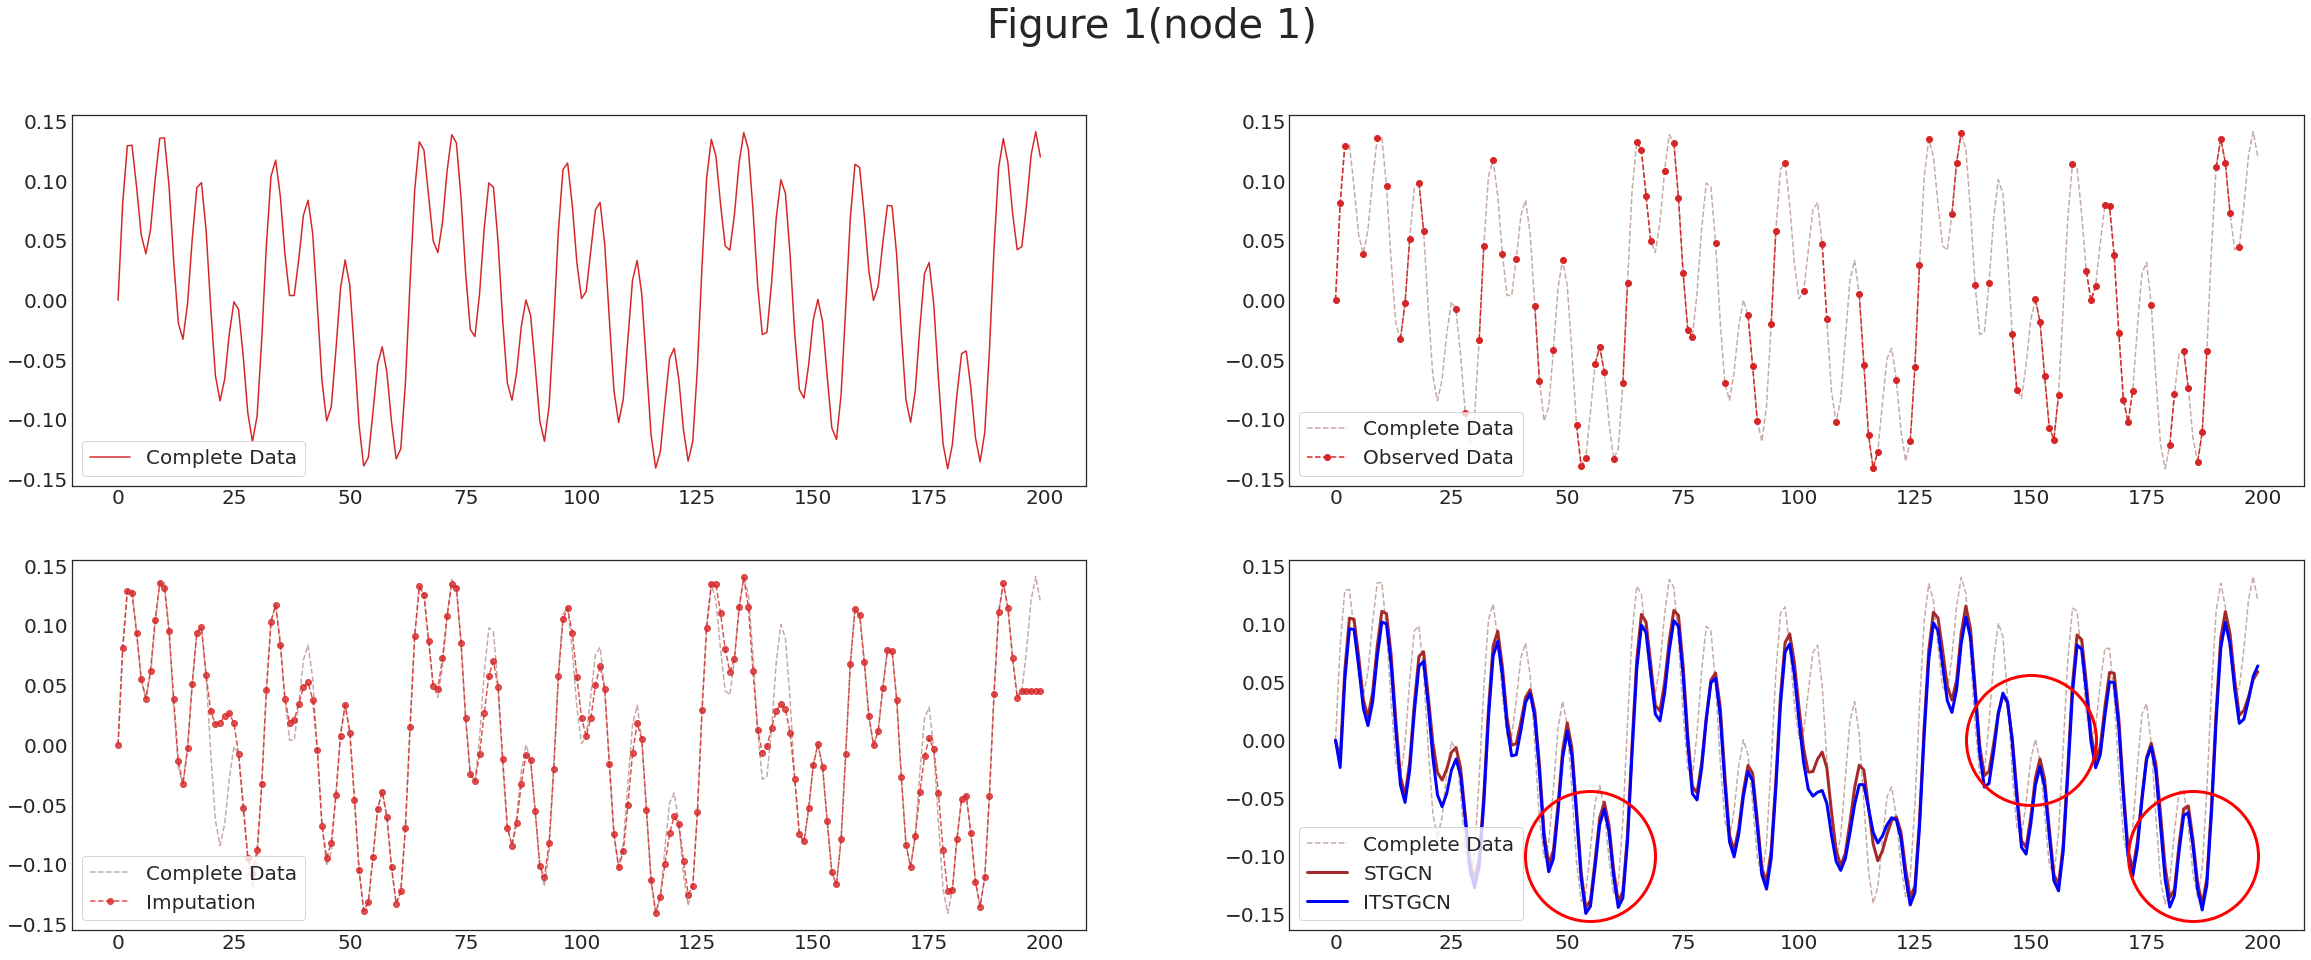

In [19]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_DyGrEncoder.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_DyGrEncoder2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_DyGrEncoder.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_DyGrEncoder2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    ax4.plot(55, -0.1, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.plot(150, 0, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.plot(185, -0.1, 'o', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

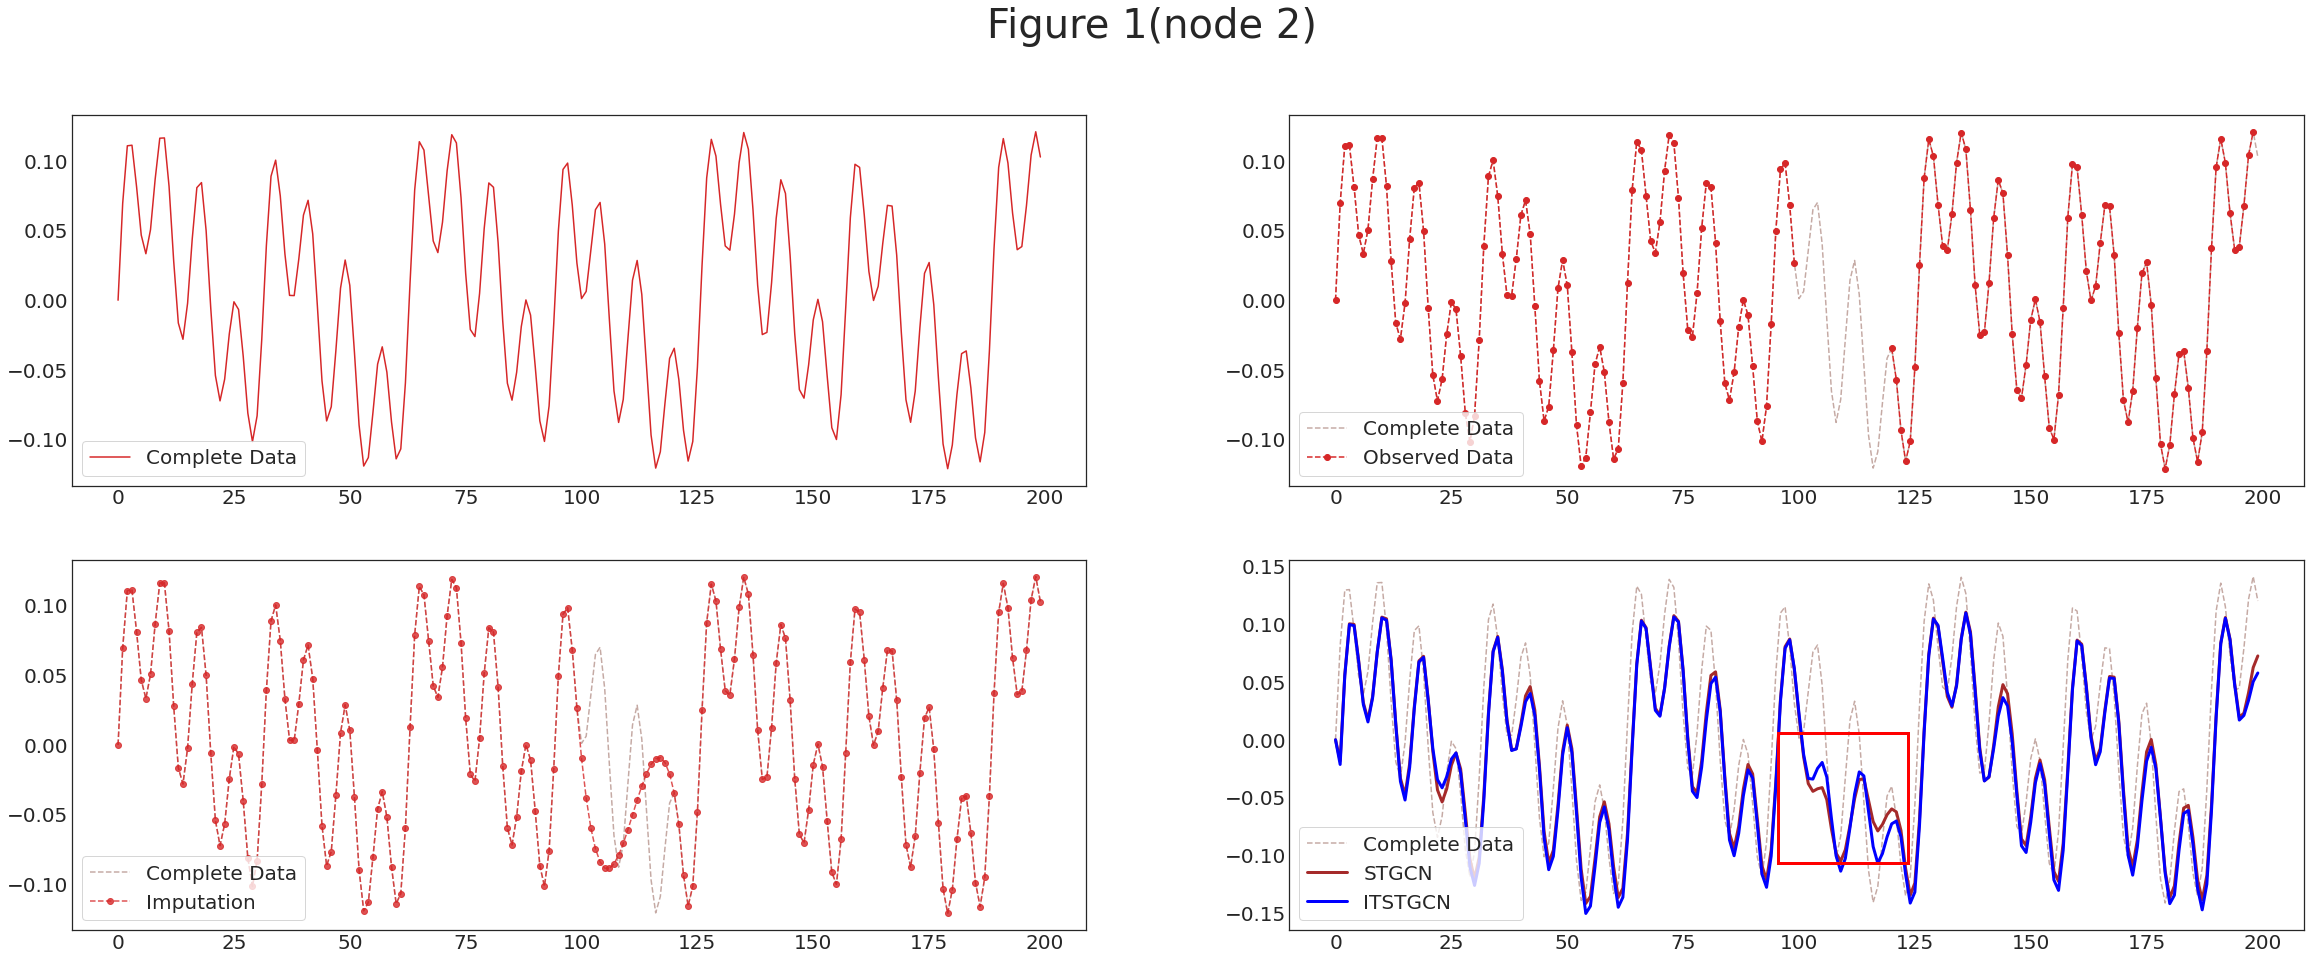

In [20]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss_DyGrEncoder.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_DyGrEncoder2.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor_DyGrEncoder.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_DyGrEncoder2.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, -0.05,'s', markersize=130, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

# d

In [30]:
import itstgcn
import numpy as np

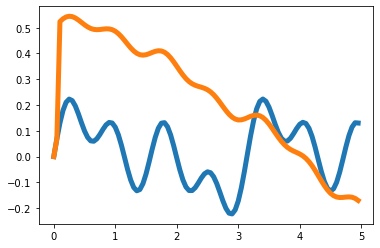

In [70]:
T = 100
t = np.arange(T)/T * 5

x = 0.1*np.sin(2*t)+0.1*np.sin(4*t)+0.1*np.sin(8*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
for i in range(2,T):
    y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.5*np.cos(0.4*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x
y = y
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [ ]:
T = 100
t = np.arange(T)/T * 5

x = 0.2*np.sin(2*t)+0.1*np.sin(4*t)+0.1*np.sin(8*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
for i in range(2,T):
    y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.15*np.cos(0.4*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x
y = y
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [ ]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [ ]:
dataset = loader1.get_dataset(lags=1)

In [ ]:
mindex = [random.sample(range(0, T), int(T*0.5)),[np.array(list(range(20,30)))]]
dataset_miss = itstgcn.miss(dataset,mindex,mtype='block')

In [ ]:
dataset_padded = itstgcn.padding(dataset_miss,interpolation_method='linear')

In [ ]:
lrnr = itstgcn.StgcnLearner(dataset_padded)

In [ ]:
lrnr.learn(filters=1,epoch=50)

In [ ]:
evtor = Eval_csy(lrnr,dataset_padded)

In [ ]:
lrnr_2 = itstgcn.ITStgcnLearner(dataset_padded)

In [ ]:
lrnr_2.learn(filters=1,epoch=50)

In [ ]:
evtor_2 = Eval_csy(lrnr_2,dataset_padded)

In [ ]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

In [ ]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_2.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_2.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, 0.1,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

In [11]:
import itstgcntry
import numpy as np
import torch

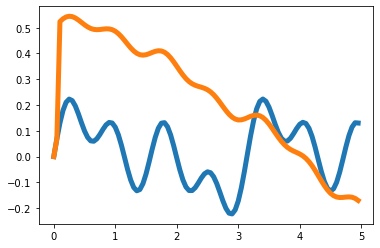

In [116]:
T = 100
t = np.arange(T)/T * 5

x = 0.1*np.sin(2*t)+0.1*np.sin(4*t)+0.1*np.sin(8*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
for i in range(2,T):
    y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.5*np.cos(0.4*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x
y = y
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
df1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

In [204]:
loader11 = itstgcntry.DatasetLoader(data_dict1)

In [205]:
dataset1 = loader11.get_dataset(lags=1)

In [206]:
mindex = [random.sample(range(0, T), int(T*0.5)),[np.array(list(range(20,35)))]]
dataset_miss1 = itstgcntry.miss(dataset1,mindex,mtype='block')
# mindex = itstgcntry.rand_mindex(dataset1,mrate=0.5)
# dataset_miss1 = itstgcntry.miss(dataset1,mindex,mtype='rand')

In [207]:
dataset_padded0 = itstgcntry.padding(train_dataset_miss1,interpolation_method='linear')

In [208]:
lrnr0 = itstgcntry.StgcnLearner(dataset_padded0)

In [209]:
model0 = itstgcntry.GConvGRU_RecurrentGCN(dataset_padded0,filters=1)

In [210]:
iter_op0 = itstgcntry.GConvGRU_iter(dataset_padded0)

In [211]:
lrnr0.learn(model0,iter_op0,epoch=50)

In [212]:
lrnr1 = itstgcntry.ITStgcnLearner(dataset_padded0)

In [213]:
model1 = itstgcntry.GConvGRU_RecurrentGCN(dataset_padded0,filters=1)

In [214]:
iter_op1 = itstgcntry.GConvGRU_iter(dataset_padded0)

In [215]:
lrnr1.learn(model1,iter_op1,epoch=50)

In [216]:
evtor0 = Eval_csy(lrnr0,dataset_padded0)

In [217]:
evtor1 = Eval_csy(lrnr1,dataset_padded0)

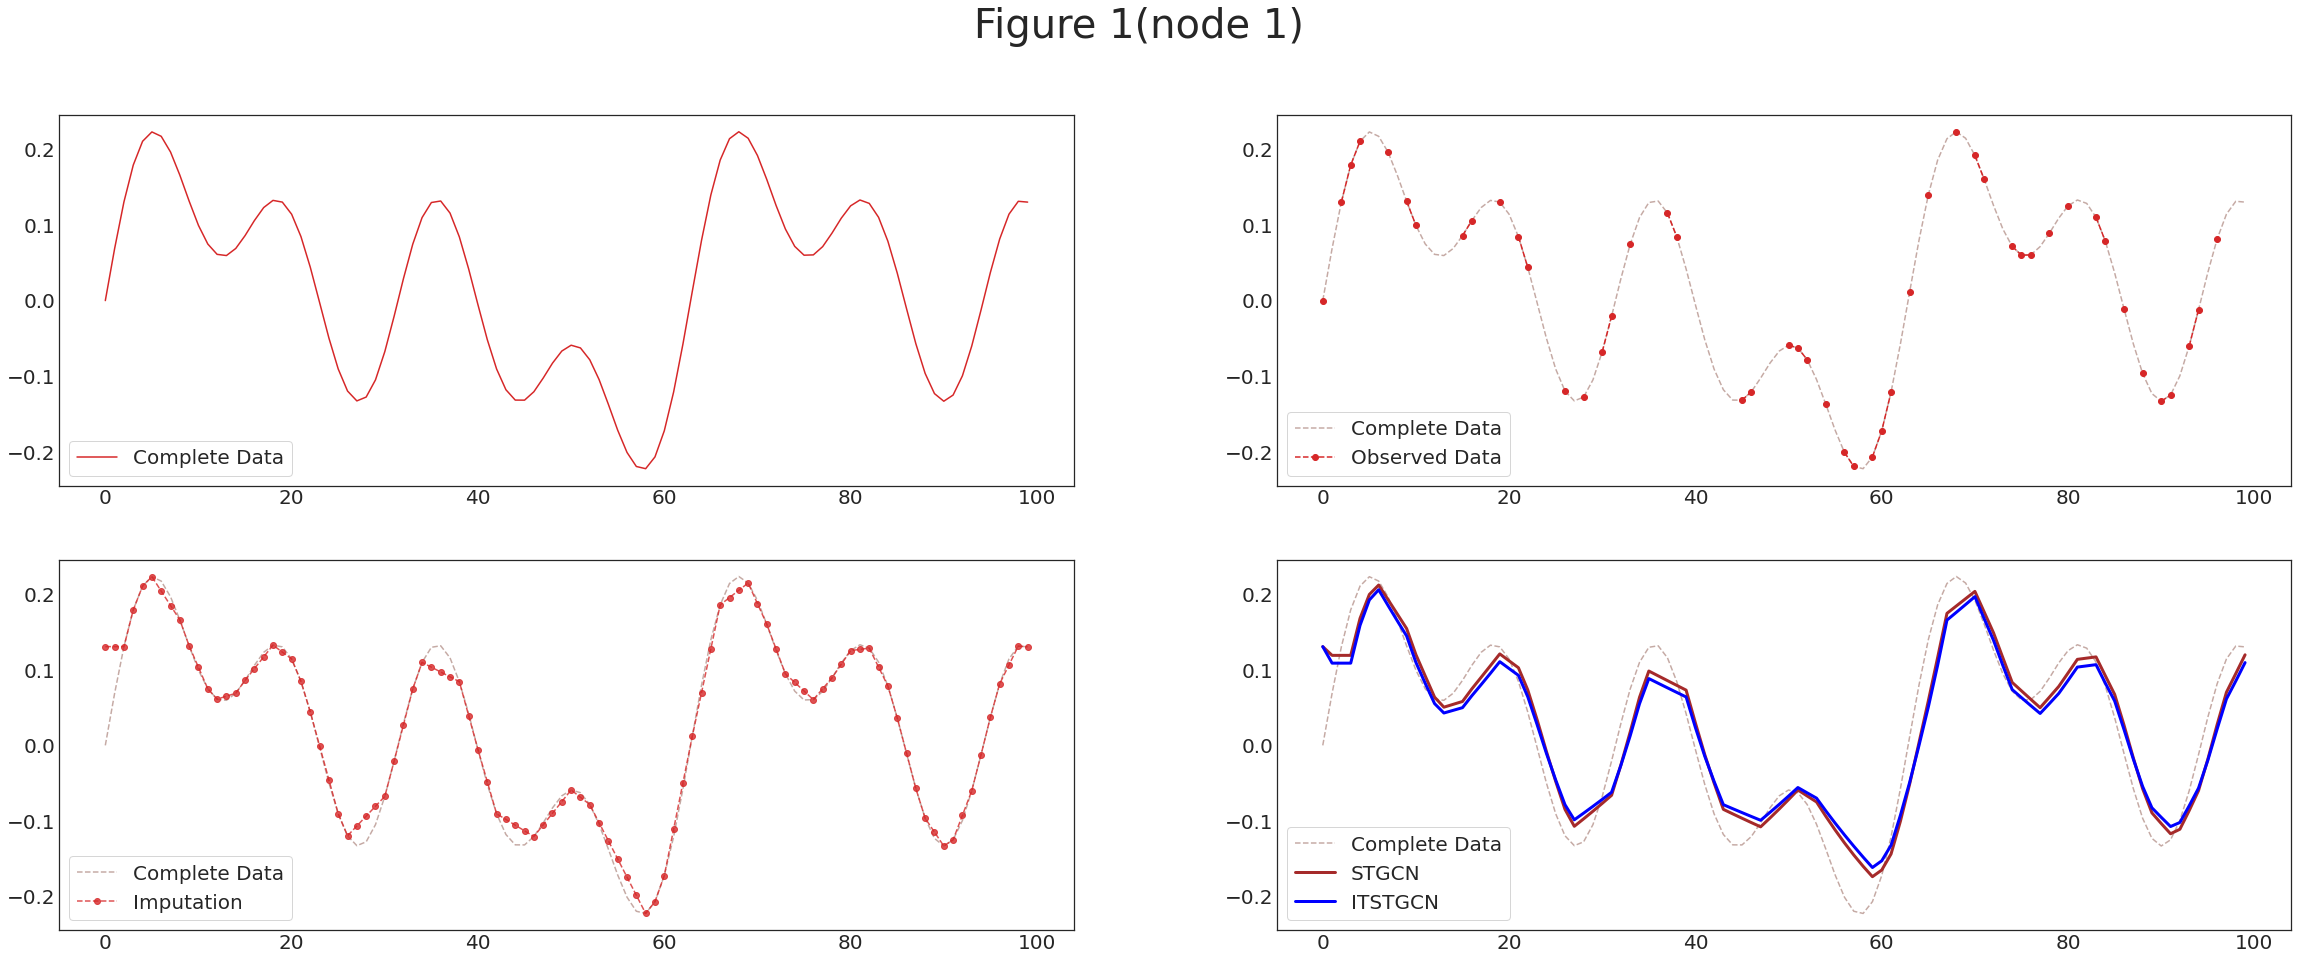

In [218]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss1.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor0.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor0.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor1.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

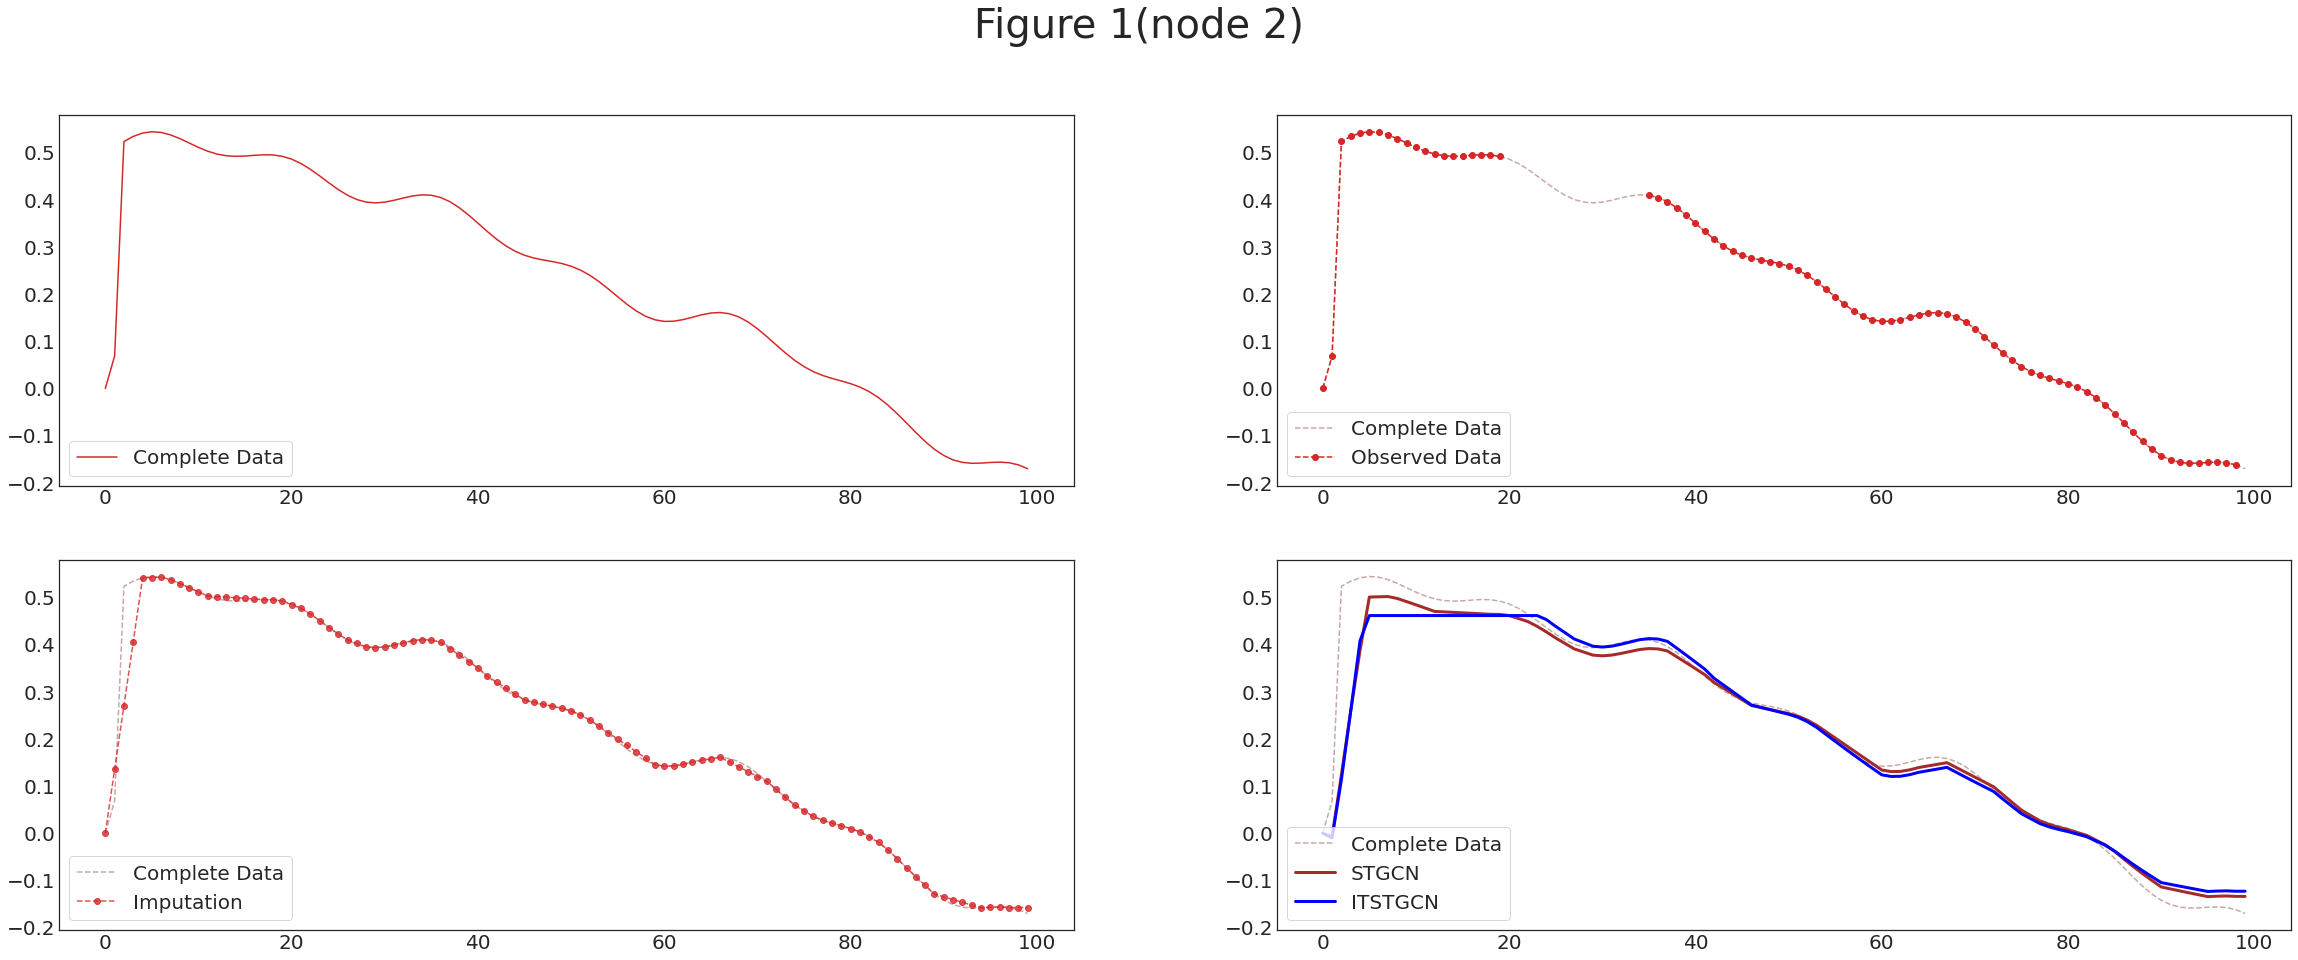

In [219]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss1.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor0.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor0.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor1.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, 0.1,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

dcrnn

In [117]:
loader11 = itstgcntry.DatasetLoader(data_dict1)

In [118]:
dataset1 = loader11.get_dataset(lags=1)

In [119]:
# mindex = [random.sample(range(0, T), int(T*0.5)),[np.array(list(range(20,35)))]]
# dataset_miss1 = itstgcntry.miss(dataset1,mindex,mtype='block')
mindex = itstgcntry.rand_mindex(dataset1,mrate=0.5)
dataset_miss1 = itstgcntry.miss(dataset1,mindex,mtype='rand')

In [120]:
dataset_padded0 = itstgcntry.padding(dataset_miss1,interpolation_method='linear')

In [121]:
lrnr0 = itstgcntry.StgcnLearner(dataset_padded0)

In [122]:
model0 = itstgcntry.DCRNN_RecurrentGCN(dataset_padded0,filters=1)

In [123]:
iter_op0 = itstgcntry.GConvGRU_iter(dataset_padded0)

In [124]:
lrnr0.learn(model0,iter_op0,epoch=50)

In [125]:
lrnr1 = itstgcntry.ITStgcnLearner(dataset_padded0)

In [126]:
model1 = itstgcntry.DCRNN_RecurrentGCN(dataset_padded0,filters=1)

In [127]:
iter_op1 = itstgcntry.GConvGRU_iter(dataset_padded0)

In [128]:
lrnr1.learn(model1,iter_op1,epoch=50)

In [129]:
evtor0 = Eval_csy(lrnr0,dataset_padded0)

In [130]:
evtor1 = Eval_csy(lrnr1,dataset_padded0)

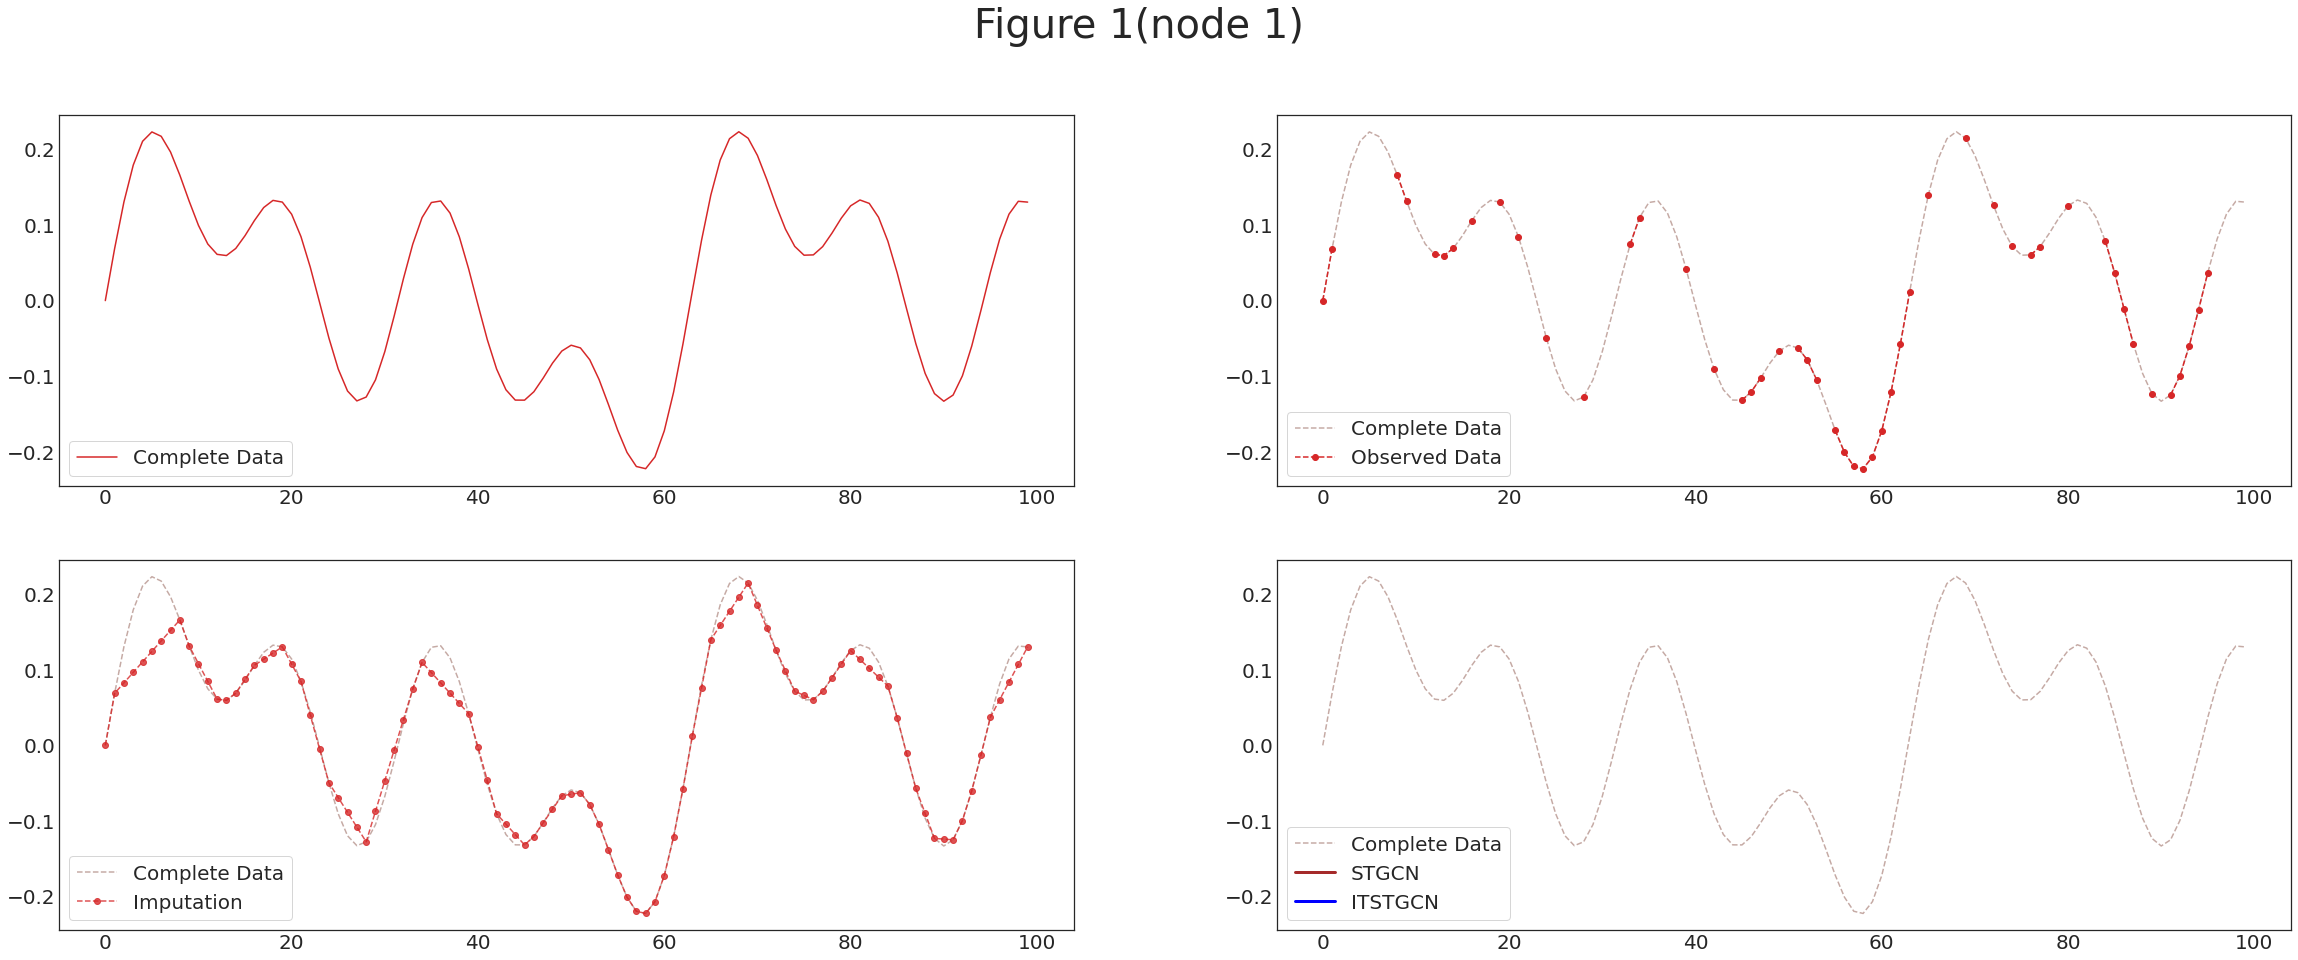

In [131]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss1.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor0.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor0.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor1.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

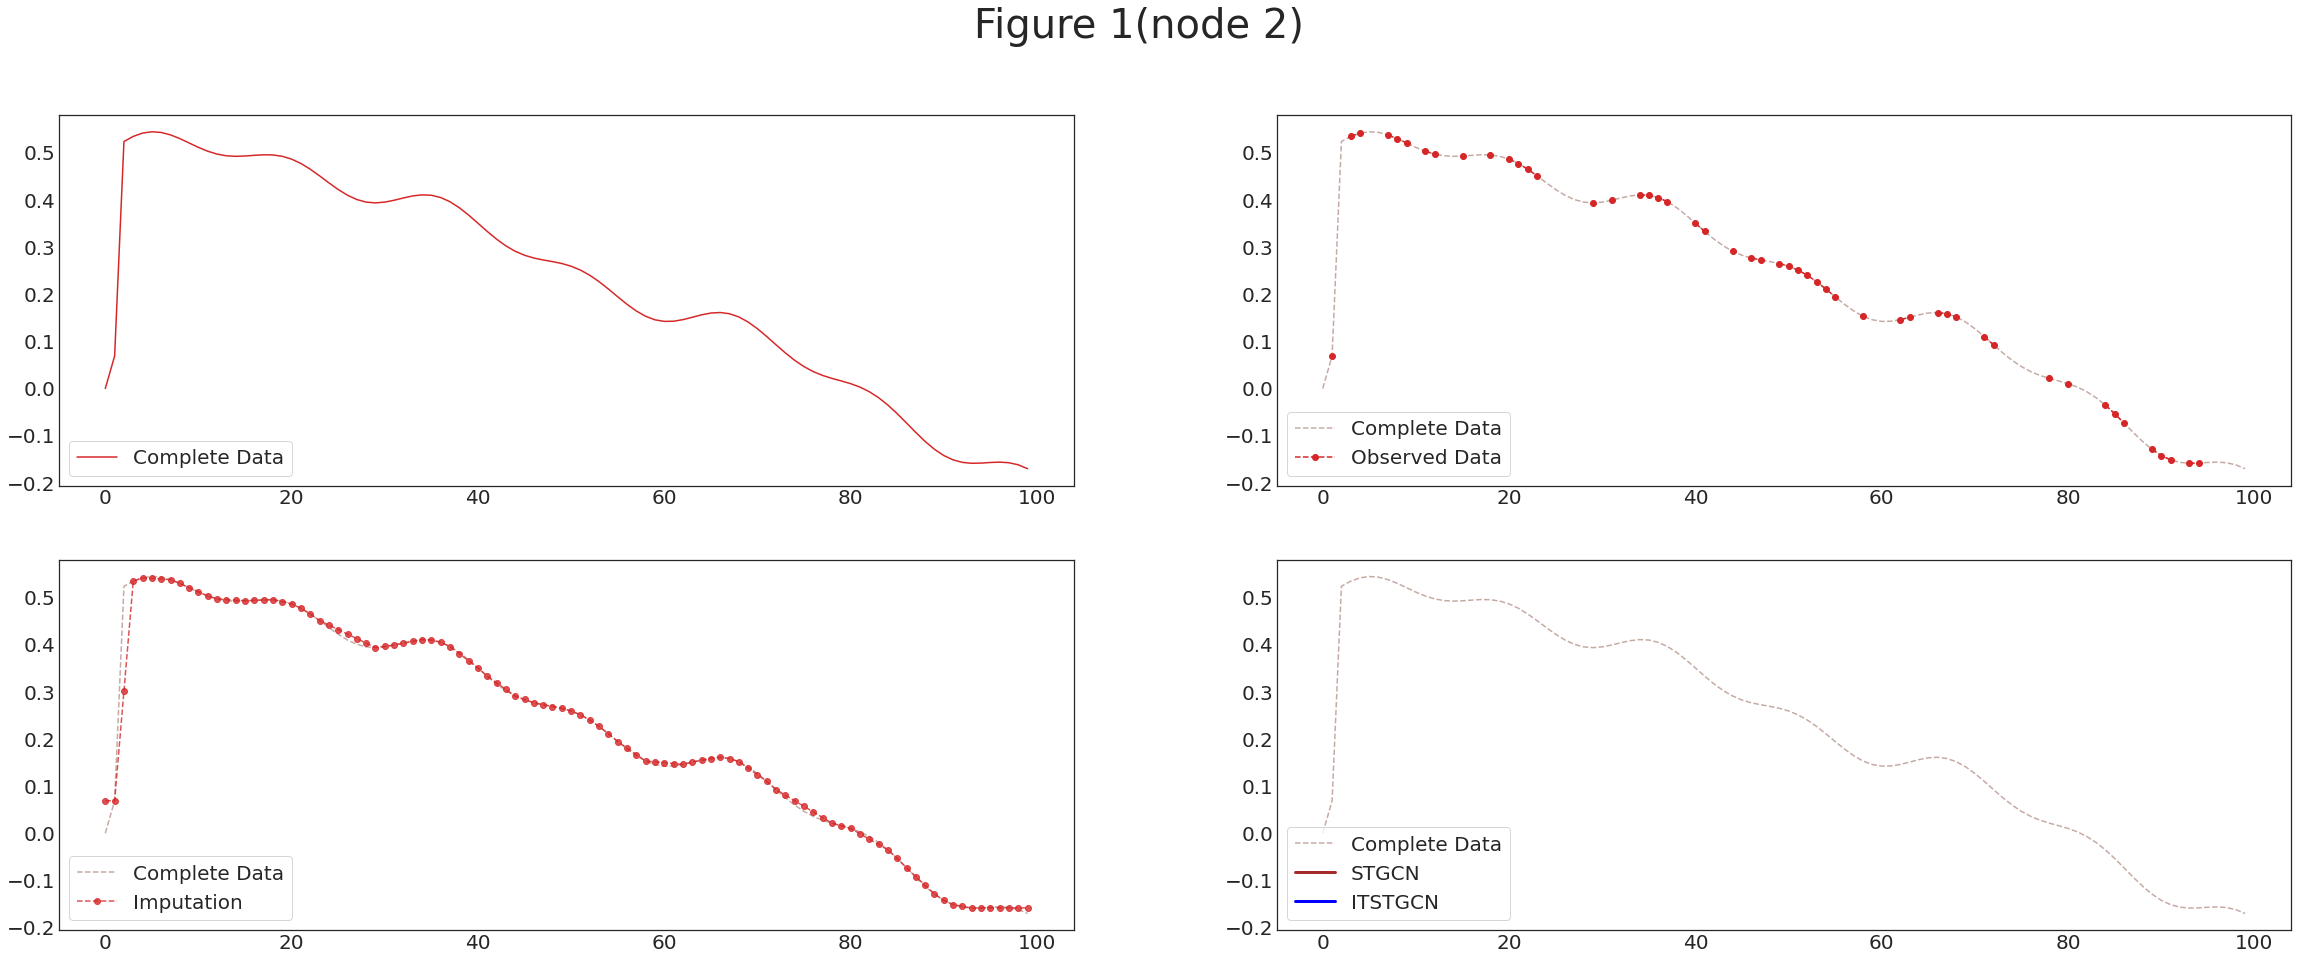

In [132]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss1.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor0.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor0.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor1.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, 0.1,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

evolvegvnn

In [133]:
lrnr0 = itstgcntry.StgcnLearner(dataset_padded0)

In [134]:
model0 = itstgcntry.EvolveGCNH_RecurrentGCN(dataset_padded0,filters=1)

In [135]:
iter_op0 = itstgcntry.GConvGRU_iter(dataset_padded0)

In [136]:
lrnr0.learn(model0,iter_op0,epoch=50)

In [137]:
lrnr1 = itstgcntry.ITStgcnLearner(dataset_padded0)

In [138]:
model1 = itstgcntry.EvolveGCNH_RecurrentGCN(dataset_padded0,filters=1)

In [139]:
iter_op1 = itstgcntry.GConvGRU_iter(dataset_padded0)

In [140]:
lrnr1.learn(model1,iter_op1,epoch=50)

In [141]:
evtor0 = Eval_csy(lrnr0,dataset_padded0)

In [142]:
evtor1 = Eval_csy(lrnr1,dataset_padded0)

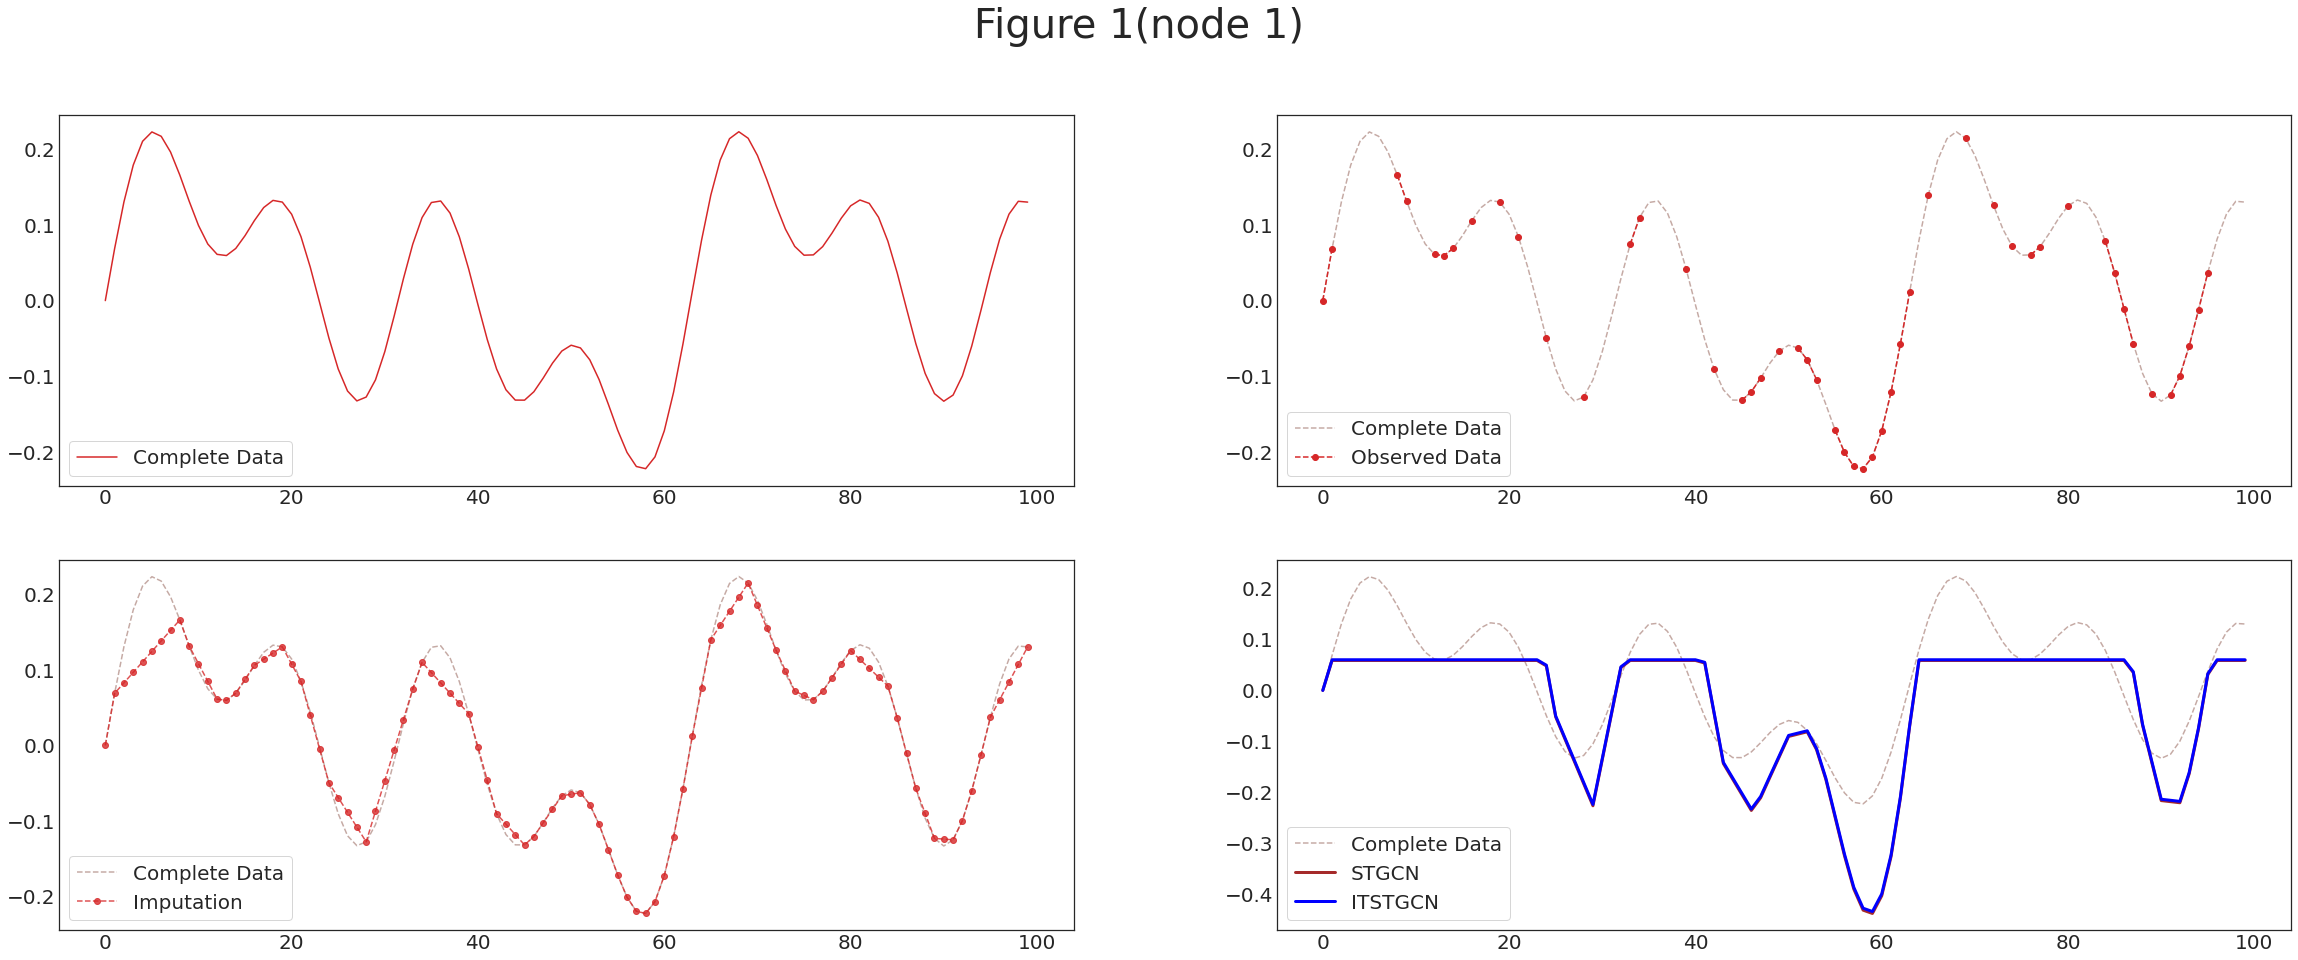

In [143]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss1.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor0.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor0.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor1.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

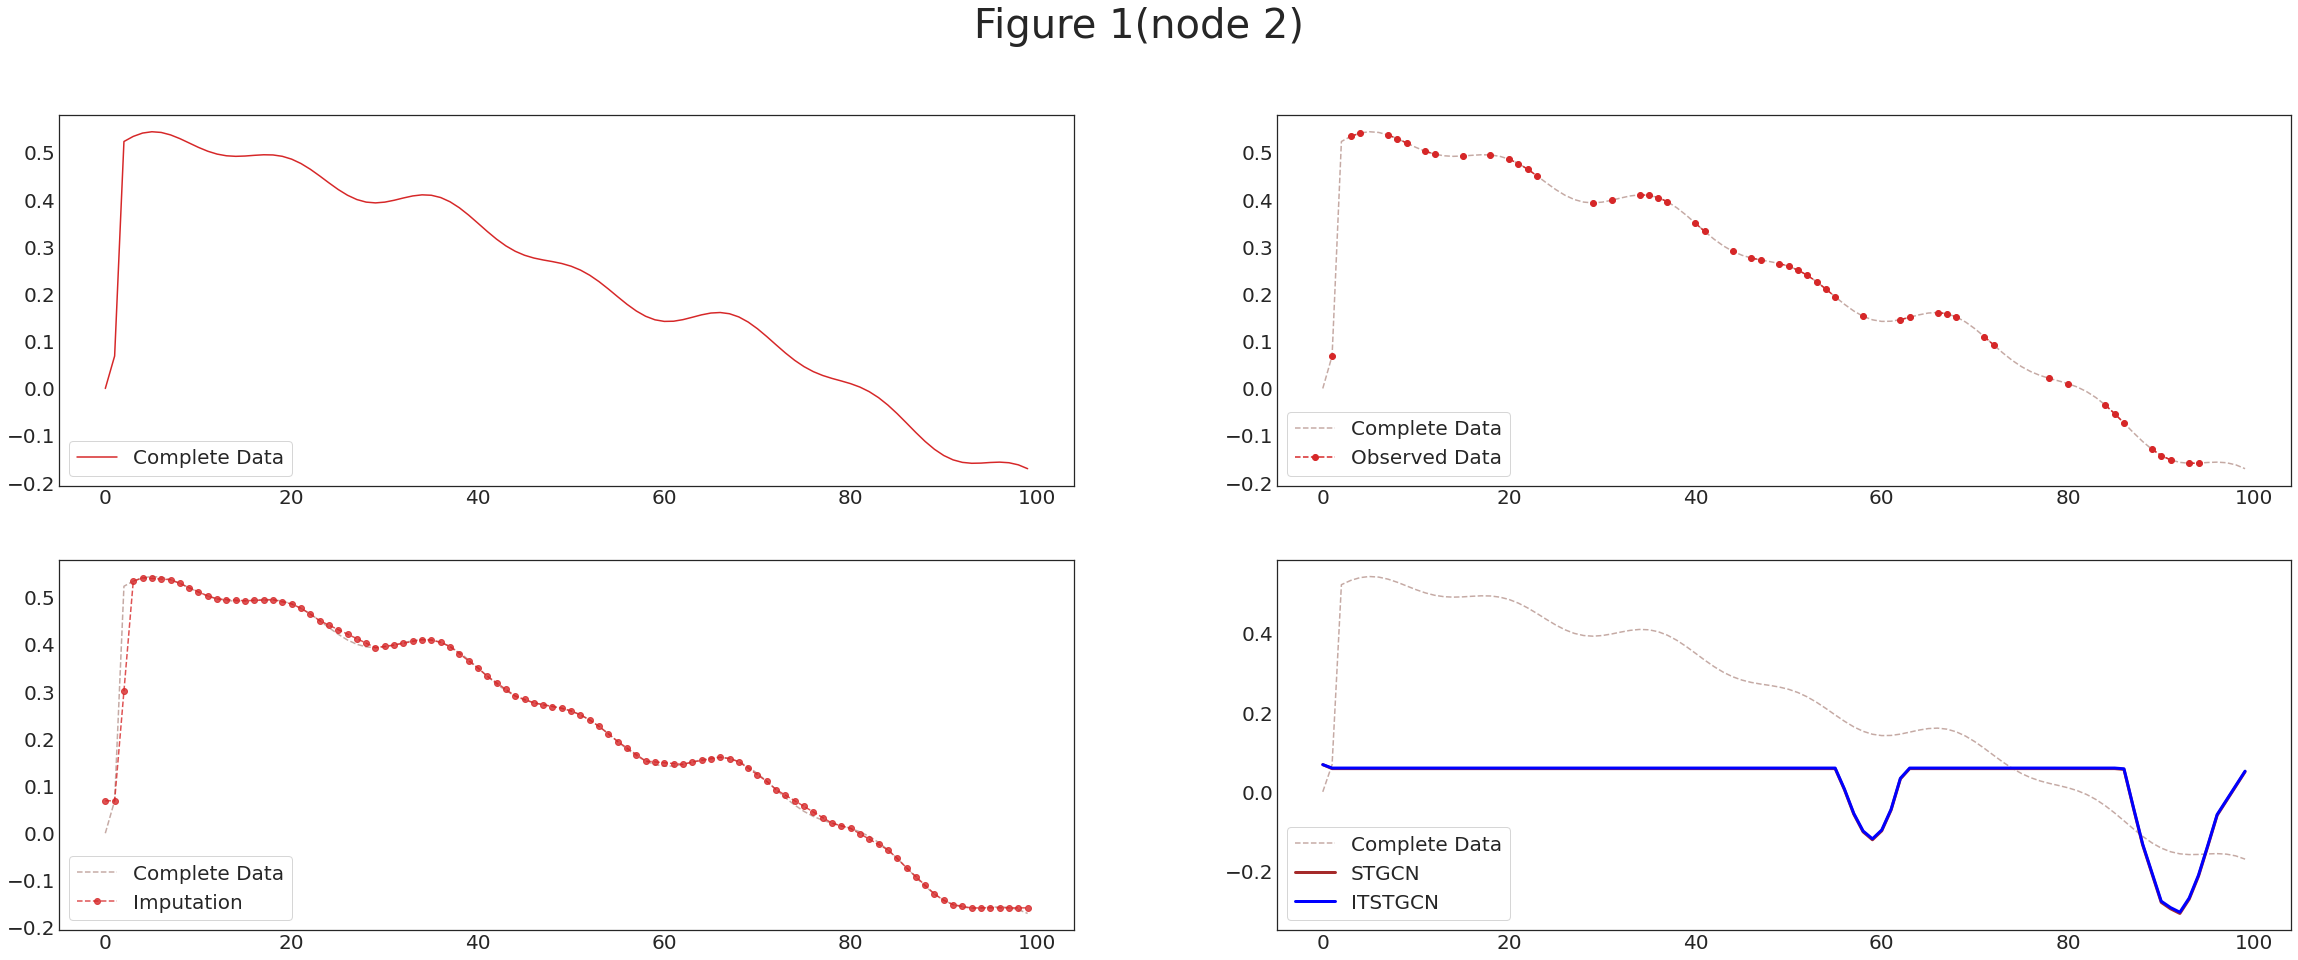

In [144]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss1.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor0.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor0.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor1.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, 0.1,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

EvolveGCNO

In [145]:
lrnr0 = itstgcntry.StgcnLearner(dataset_padded0)

In [146]:
model0 = itstgcntry.EvolveGCNO_RecurrentGCN(dataset_padded0,filters=1)

In [147]:
iter_op0 = itstgcntry.GConvGRU_iter(dataset_padded0)

In [148]:
lrnr0.learn(model0,iter_op0,epoch=50)

In [149]:
lrnr1 = itstgcntry.ITStgcnLearner(dataset_padded0)

In [150]:
model1 = itstgcntry.EvolveGCNO_RecurrentGCN(dataset_padded0,filters=1)

In [151]:
iter_op1 = itstgcntry.GConvGRU_iter(dataset_padded0)

In [152]:
lrnr1.learn(model1,iter_op1,epoch=50)

In [153]:
evtor0 = Eval_csy(lrnr0,dataset_padded0)

In [154]:
evtor1 = Eval_csy(lrnr1,dataset_padded0)

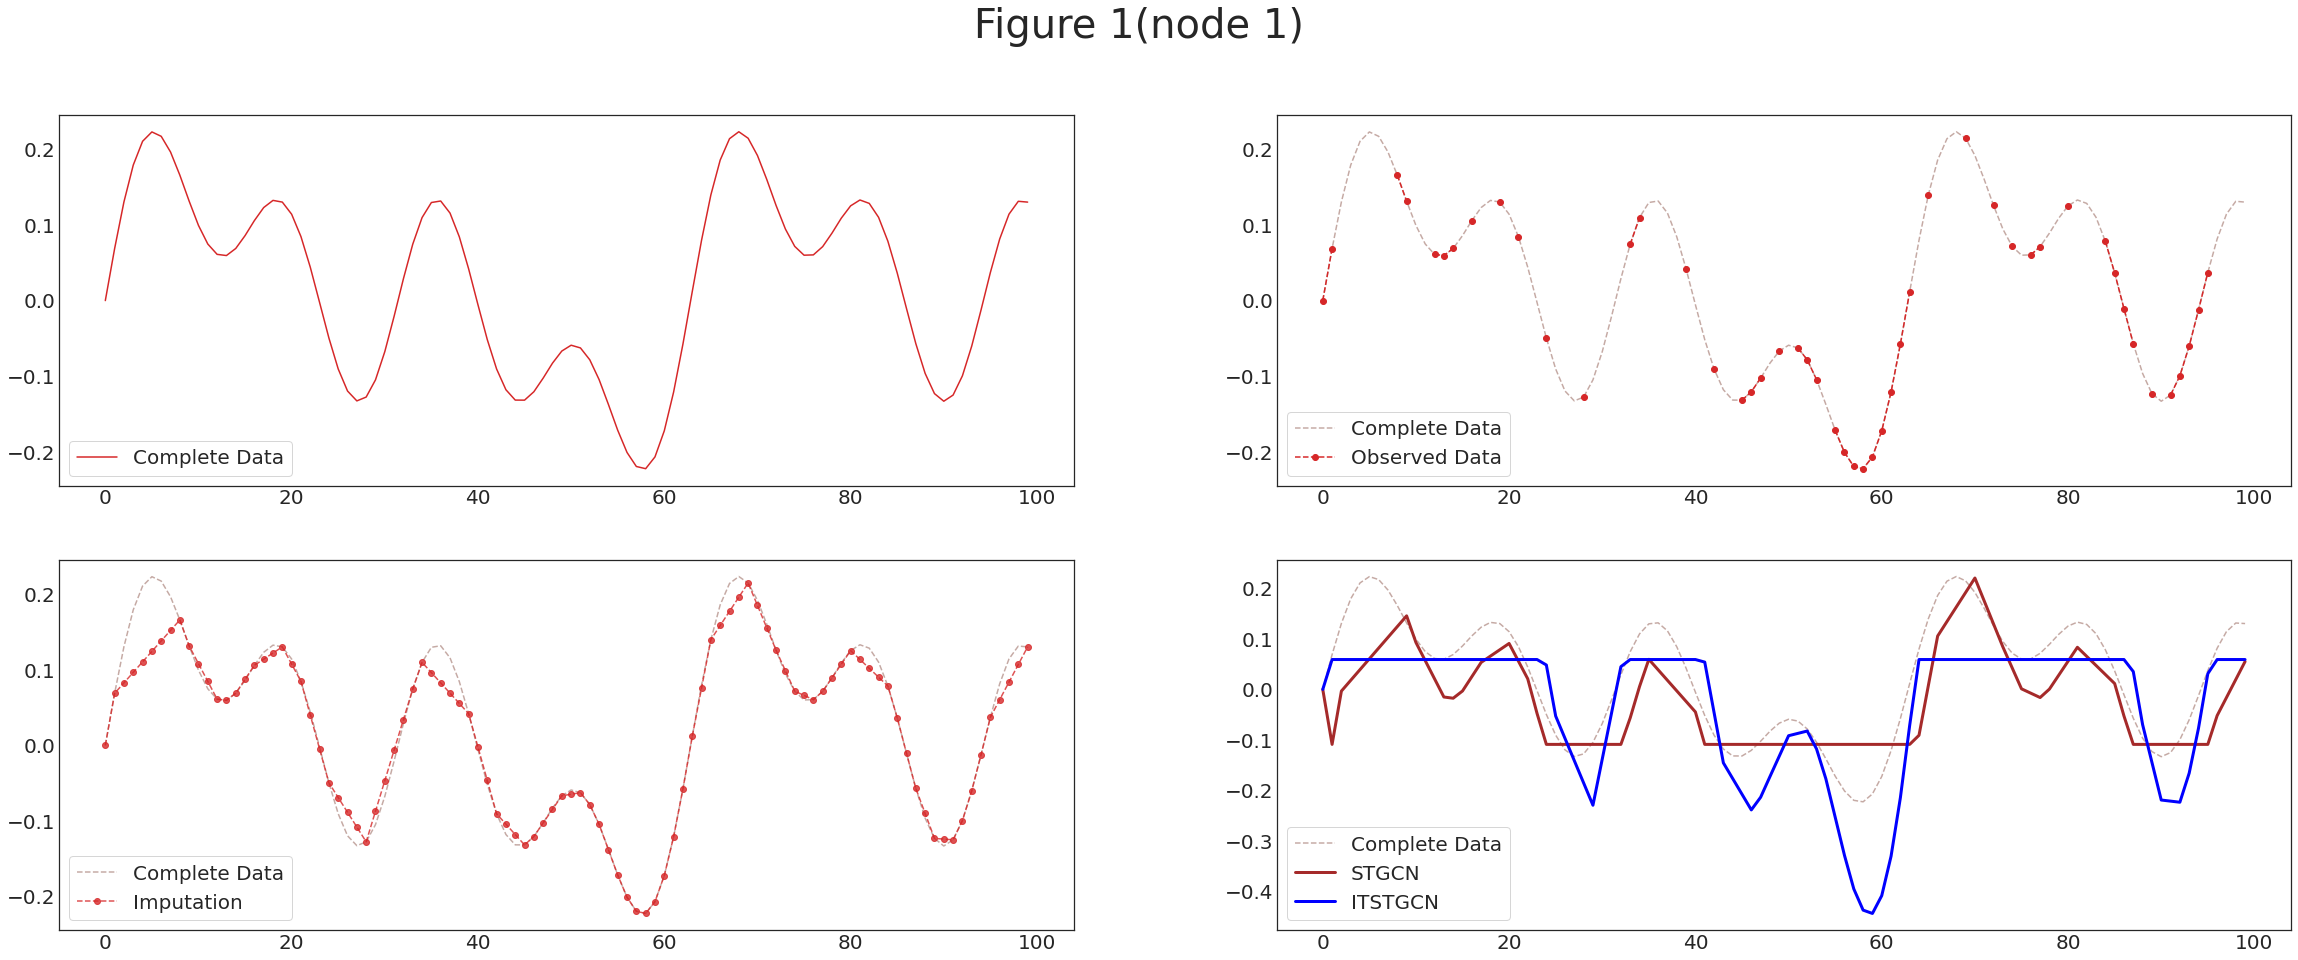

In [155]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss1.features).reshape(-1,2)[:,0],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor0.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor0.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor1.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

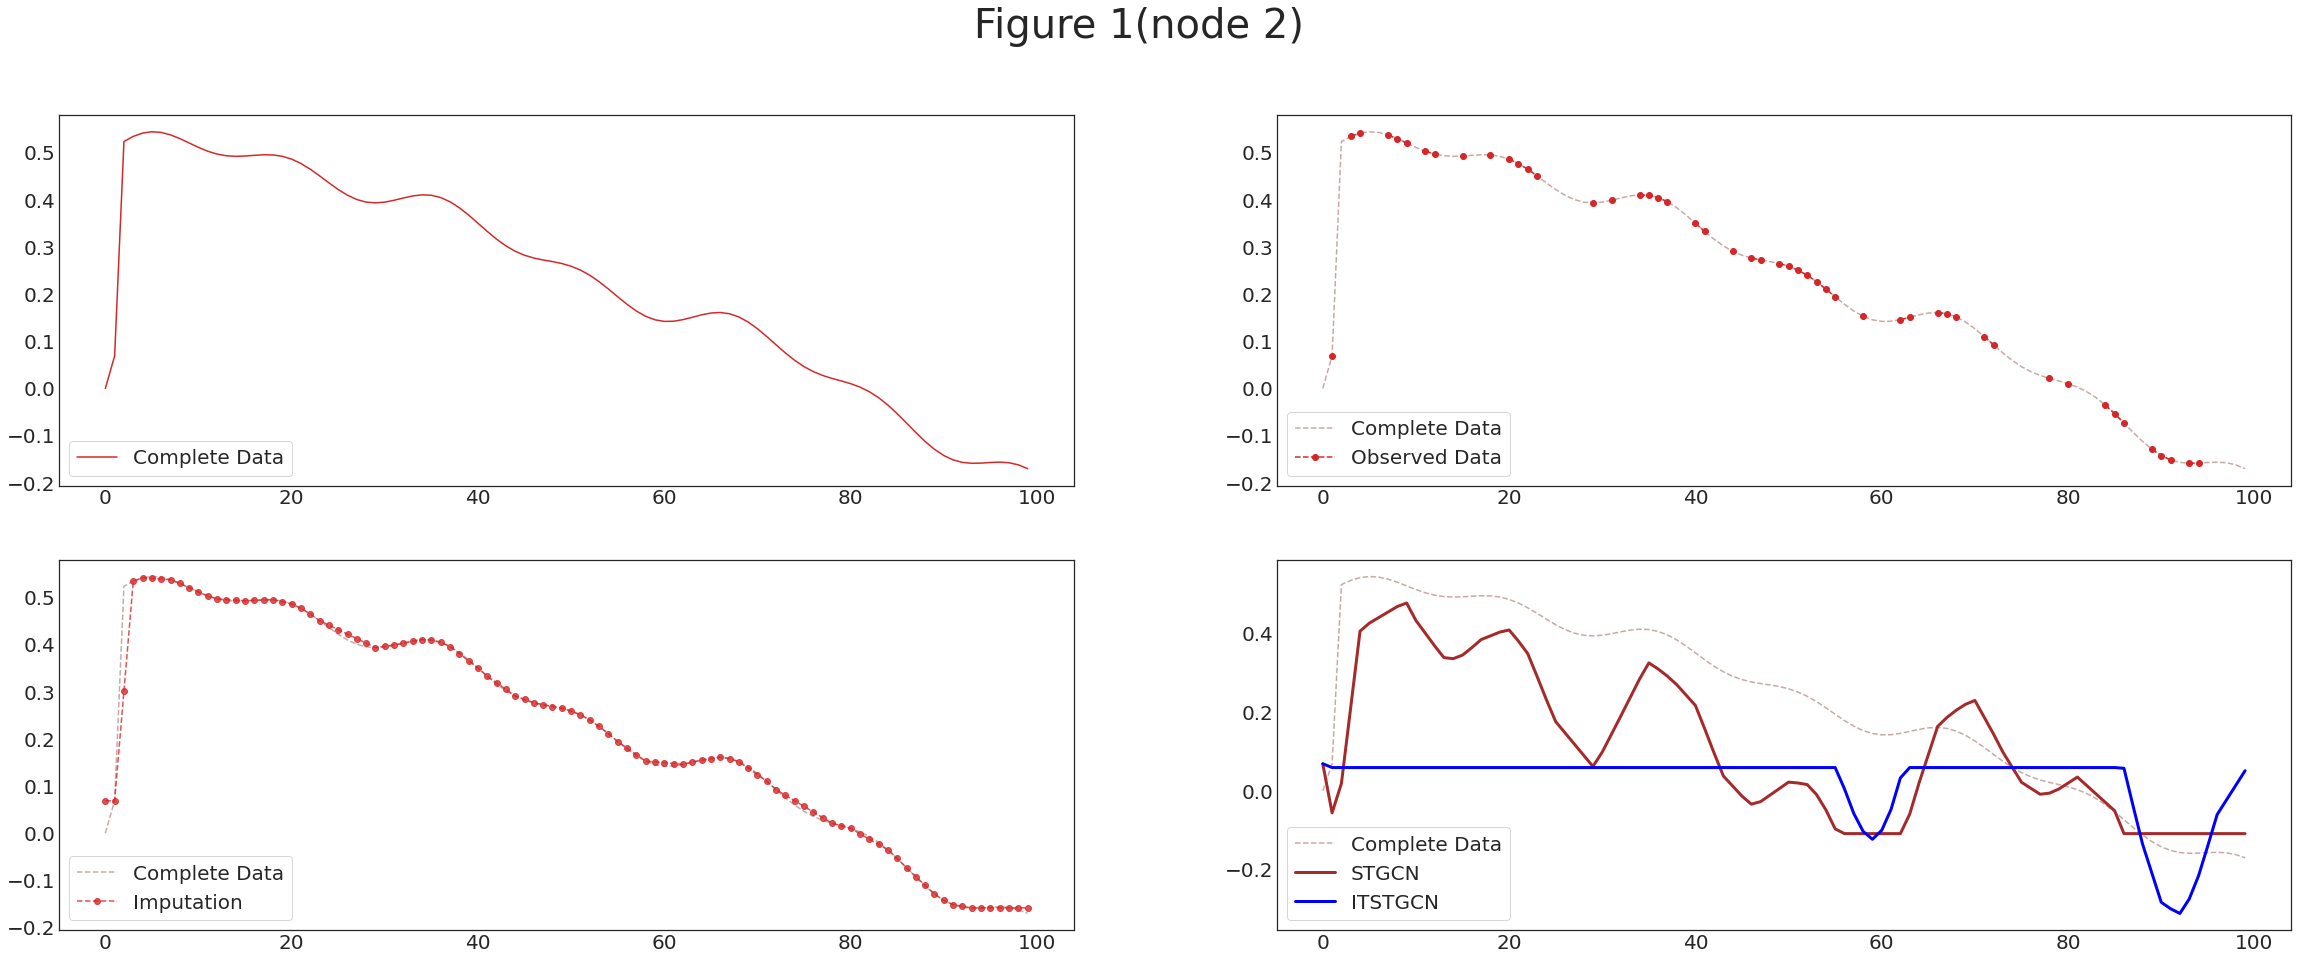

In [156]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss1.features).reshape(-1,2)[:,1],'--o',color='C3',label='Observed Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor0.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor0.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor1.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot((mindex[1][0][0]+mindex[1][0][len(mindex[1][0])-1])/2, 0.1,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)